**Assignment_3**\
**Fake Reddit Prediction**\
**Ahmed Mohamed Gaber**\
**21AMGA**

##Import libraries

In [2]:
# used for fast mathematical operations on arrays and linear algebra operations
import numpy as np
# pandas is used for tabular data preprocessing
import pandas as pd
#for virtualization
import seaborn as sns
#Set aesthetic parameters in one step.
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline # used to combine several transforms into a sequence of operations 

#for ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

#for spliting the data and use GridSearchCV , RandomizedSearchCV,  for tunning multiple hyperparameters 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, PredefinedSplit

#virtualization for roc_curve
from sklearn.metrics import roc_curve , roc_auc_score

#feature extraction from text
from sklearn.feature_extraction.text import TfidfVectorizer

#metrics for reports and vertualization
from sklearn.metrics import roc_curve , roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn import metrics

#data preprocessing for text
import re
from nltk.stem.snowball import SnowballStemmer
import nltk
from nltk.corpus import stopwords

#Load the data

In [13]:
# import data from my google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
#read the data into data frame
df = pd.read_csv('/content/drive/MyDrive/DEBI/Queens/DM/Assignment_3/xy_train.csv')
#display the first 5 rows of dataframe
df.head()

,id,text,label
0,265723,A group of friends began to volunteer at a hom...,0
1,284269,British Prime Minister @Theresa_May on Nerve A...,0
2,207715,"In 1961, Goodyear released a kit that allows P...",0
3,551106,"Happy Birthday, Bob Barker! The Price Is Right...",0
4,8584,"Obama to Nation: 聙""Innocent Cops and Unarmed Y...",0


#First Trial For Data Preprocessing

>Overview
 * for this trial i will do a few things like i will check for missing values and drop the missing values if that exist and i will check the unique values of target column and handle this column and then i will check for duplicates and handeling that problems and then i will use tfidfvectors to handle the another things by using the default hyperparameters

##Handel the null values

i will check if there ara any null values or not to handle that problem if exist

In [ ]:
#check for the columns which have the heights nun values
df.isnull().sum().sort_values(ascending=False)

id       0
text     0
label    0
dtype: int64

as we see the data has zero null values which is good

In [ ]:
#virtualize the data correlation
corr = df.corr()

corr.style.background_gradient(cmap="Spectral")

,id,label
id,1.000000,0.000687
label,0.000687,1.000000


##Handling the target column

Checking the uniques values for label column because the range of label column must be zero or one

In [ ]:
#print the unique values
df['label'].value_counts()

0    32172
1    27596
2      232
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


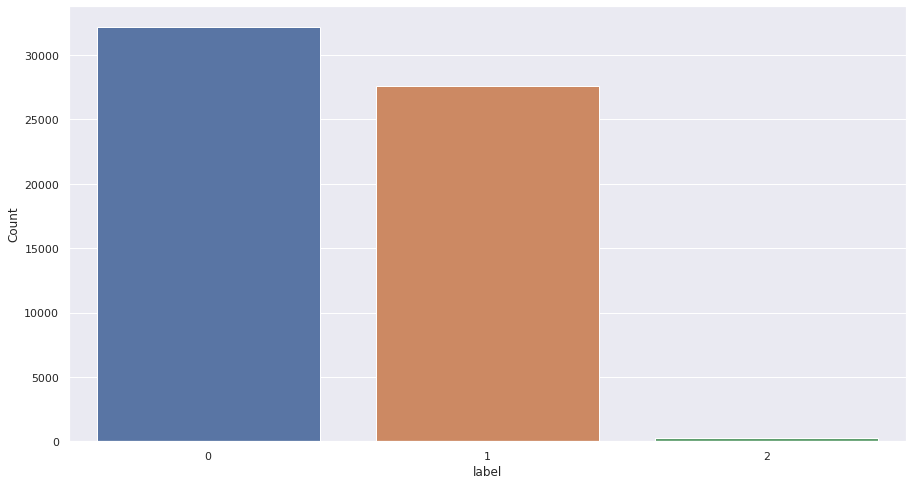

In [ ]:
# checking for distribution of label column before handling
fig, ax = plt.subplots(figsize = (15, 8))
sns.countplot('label', data = df, order = df['label'].value_counts().index, ax = ax)
ax.set(xlabel='label', ylabel='Count')
plt.show()

as we see we have 3 unique values for label column so i will convert all label value (2) to be (1) in this trial

i will create new column (grade_bad) has all values 0 then check on the label column then i will update the values in grade_bad column
* if label column has value 0 then i will fill grade_bad with (zero)
* else if the label column has value more than (zero) i will fill grade_bad with (one)

In [ ]:
#create new column has the new target data after handling
df["new_label"] = 0
df.loc[df["label"] == 0, "new_label"] = 0
df.loc[df["label"] > 0, "new_label"] = 1

In [ ]:
#checking for the distribution of grade_bad
df['new_label'].value_counts()

0    32172
1    27828
Name: new_label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


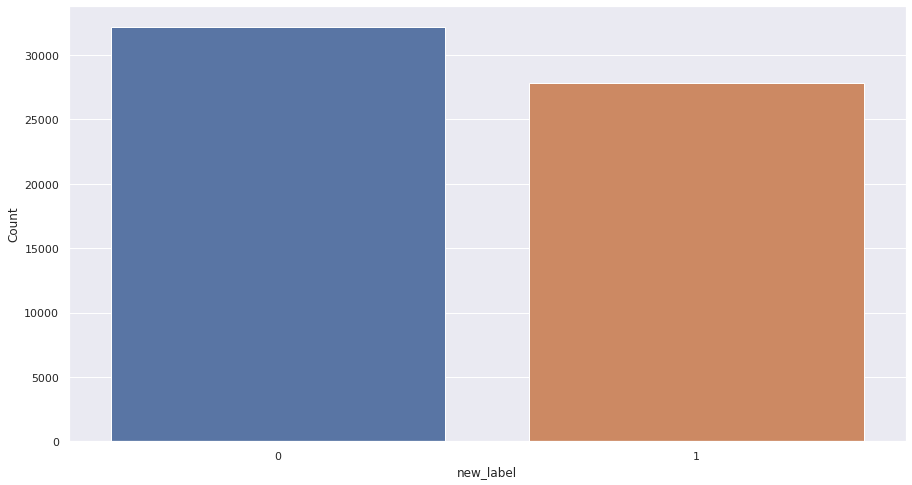

In [ ]:
# checking for distribution of new_label column after handling
fig, ax = plt.subplots(figsize = (15, 8))
sns.countplot('new_label', data = df, order = df['new_label'].value_counts().index, ax = ax)
ax.set(xlabel='new_label', ylabel='Count')
plt.show()

now we have new target column with values (0, 1)

In [ ]:
#Checking if the new_label is balance or not
df["new_label"].value_counts(normalize=True)

0    0.5362
1    0.4638
Name: new_label, dtype: float64

as we see the data is balance which is good

##handling the duplication

In [ ]:
#describe the text column
df['text'].describe()

count                                                 60000
unique                                                59645
top       /r/Fakehistoryporn subscribers as they attempt...
freq                                                     14
Name: text, dtype: object

as we see we have 59645 unique values out of 60000 rows so we have a duplicated values but in the first i will let them and try my model then i will remove them and compare the results

---

#split the data to features and target

**target data**

In [ ]:
# but the new_label column in Y which is the target value
Y = df['new_label']
print(Y.shape)

(60000,)


**Features Data**

In [ ]:
#put the text column in X
X = df['text']
#print the shape for features
print(X.shape)

(60000,)


Split the training data into training set and test set to test results local 

In [ ]:
#split the training set into 90% training and 10% test to test this results local before i use kaggle
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (54000,)
X_test: (6000,)
y_train: (54000,)
y_test: (6000,)


#Pipeline Models

##Trail_1 (XGBClassifier)

> in this trial i will use XGBClassifier with pipeline and using tfidfvectorizer with the default hyperparameters

in this model i expect to give me score around 90% on training and 90% auc on test set

In [ ]:
# step 1: using TfidfVectorizer with default hyperparameters
# step 2: using XGBClassifier
pipe_XGB_Clf = Pipeline(
                        [('tfidf', TfidfVectorizer()),
                        ('XGB', XGBClassifier(objective='binary:logistic', subsample = 0.7, colsample_bytree =  0.7, n_estimators = 200, max_depth = 16, random_state=42))
                        ])

#fit the model and print the score the model
pipe_XGB_Clf.fit(X_train, y_train)  
pipe_XGB_Clf.score(X_train, y_train)

0.8875740740740741

> **Virtualization and report for this model**

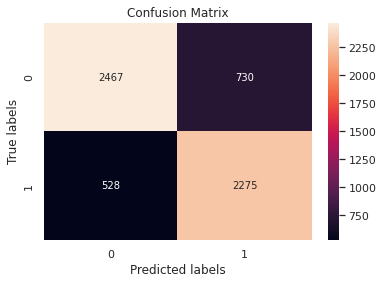

In [ ]:
#using the training model to predict the test set
predictions = pipe_XGB_Clf.predict(X_test)

#Calculating Confusion Matrix
CM = confusion_matrix(y_test, predictions)

# drawing confusion matrix
ax= plt.subplot()
sns.heatmap(CM, annot=True, fmt='g', ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

In [ ]:
#Calculating classification Report (precision, recall, f1-score, accuracy) on test set:  

ClassificationReport = classification_report(y_test, predictions)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.82      0.77      0.80      3197
           1       0.76      0.81      0.78      2803

    accuracy                           0.79      6000
   macro avg       0.79      0.79      0.79      6000
weighted avg       0.79      0.79      0.79      6000



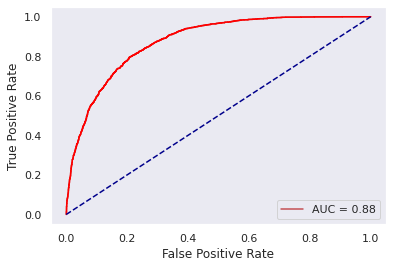

In [ ]:
#calculate and virtualize the roc curve for the test set

fpr, tpr, thresholds = roc_curve(y_test, pipe_XGB_Clf.predict_proba(X_test)[:,1])

roc_auc = roc_auc_score(y_test, pipe_XGB_Clf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr, tpr, color='red', label='')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.grid()

In [ ]:
#predict and create CSV file for CSV test file
df2 = pd.read_csv('/content/drive/MyDrive/DEBI/Queens/DM/Assignment_3/x_test.csv')
submission = pd.DataFrame()
submission['id'] = df2['id']
submission['label'] = pipe_XGB_Clf.predict_proba(df2['text'])[:, 1]

submission.to_csv('No_pre_XGB_trial_1.csv', index=False)

#kaggel  0.83795

* as we see from the previous virtualization and test i got 88.7% score which it's close to my expectation and good 
* and give me 79% score on test data 
* and give me 88% auc on test data which it's close to my expectation and good
* and give me 83.7 % on kaggle

> from all of that this model not bad and also not good i will try another model to see if there is any improvement or not



##Trail_2 (LogisticRegression with GridSearch)

> in this trial i will use LogisticRegression Model with GridSearch approach by using pipeline and using tfidfvectorizer with the default hyperparameters

in this model i expect to give me score around 90% on training and 90% auc on test set

In [ ]:
# step 1: using TfidfVectorizer with default hyperparameters
# step 2: using LR Model
pipe_LR_Clf = Pipeline([('tfidf', TfidfVectorizer()),
                       ('LR_Grid', LogisticRegression(max_iter = 600, random_state=42))
                       ])

#fit the model and print the score the model
pipe_LR_Clf.fit(X_train, y_train)
pipe_LR_Clf.score(X_train, y_train)

0.873

> using the GridSearch for hyperparameters tuning 

In [ ]:
#for calculate the time of run
%%time
#the possiple hyperparameters for tuning
params = {
    "LR_Grid__solver": [ 'lbfgs', 'liblinear', 'saga'],
    "LR_Grid__C": np.arange(0.1, 1, 0.1),
    "LR_Grid__penalty":['l1', 'l2', 'none']
}

#Tune by GridSearch with scoring roc_auc
pipe_LR_Grid_clf = GridSearchCV(pipe_LR_Clf, params, n_jobs=-1, cv = 2, verbose=2, scoring="roc_auc")
#fit the gridsearch model
pipe_LR_Grid_clf.fit(X_train, y_train)

Fitting 2 folds for each of 81 candidates, totalling 162 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
36 fits failed out of a total of 162.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fi

CPU times: user 12.3 s, sys: 1.2 s, total: 13.5 s
Wall time: 6min 26s


In [ ]:
#best score and hyperparameter from tunning
print('best score {}'.format(pipe_LR_Grid_clf.best_score_))
best_params = pipe_LR_Grid_clf.best_params_
print(best_params)

best score 0.8831155259349588
{'LR_Grid__C': 0.9, 'LR_Grid__penalty': 'l2', 'LR_Grid__solver': 'saga'}


In [ ]:
# run pipe with best hyperparameters
pipe_LR_Clf.set_params(**best_params).fit(X_train, y_train)
pipe_pred = pipe_LR_Clf.predict_proba(X_test)

> **Virtualization and report for this model**

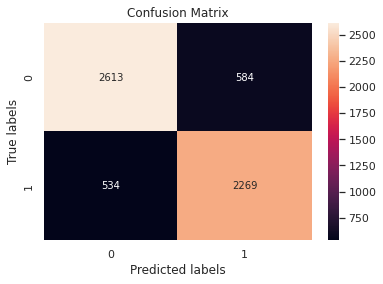

In [ ]:
predictions = pipe_LR_Clf.predict(X_test)
#Calculating Confusion Matrix
CM = confusion_matrix(y_test, predictions)

# drawing confusion matrix
ax= plt.subplot()
sns.heatmap(CM, annot=True, fmt='g', ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

In [ ]:
#Calculating classification Report (precision, recall, f1-score, accuracy) on test set:  

ClassificationReport = classification_report(y_test, predictions)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.83      0.82      0.82      3197
           1       0.80      0.81      0.80      2803

    accuracy                           0.81      6000
   macro avg       0.81      0.81      0.81      6000
weighted avg       0.81      0.81      0.81      6000



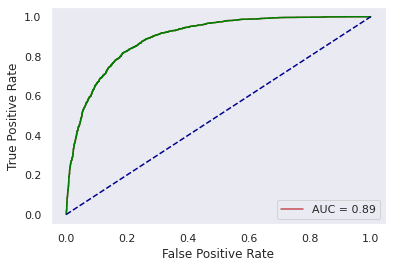

In [ ]:
#calculate and virtualize the roc curve for the test set
fpr, tpr, thresholds = roc_curve(y_test, pipe_LR_Clf.predict_proba(X_test)[:,1])

roc_auc = roc_auc_score(y_test, pipe_LR_Clf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr, tpr, color='green', label='')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.grid()

In [ ]:
#predict and create CSV file for CSV test file
df2 = pd.read_csv('/content/drive/MyDrive/DEBI/Queens/DM/Assignment_3/x_test.csv')
submission = pd.DataFrame()
submission['id'] = df2['id']
submission['label'] = pipe_LR_Clf.predict_proba(df2['text'])[:, 1]

submission.to_csv('No_pre_LR_Grid_trial_1.csv', index=False)

#kaggel  0.86157

* as we see from the previous virtualization and test 
* i got 88.3% best score which it's close to my expectation and good 
* and give me 81% score on test data which is good
* and give me 89% auc on test data which it's close to my expectation and good and this is better than the previous one 
* and give me 86.157 % on kaggle which it's the best one untill now

> from all of that this model not bad and it's good model but i will try another model to see if there is any improvement or not



##Trail_3 (RandomForest with RandomSearch)

> in this trial i will use RandomForest Model with RandomSearch approach by using pipeline and using tfidfvectorizer with the default hyperparameters

in this model i expect to give me score around 85% on training and 85% auc on test set

In [ ]:
# step 1: using TfidfVectorizer with default hyperparameters
# step 2: using RF Model
pipe_RF_Clf = Pipeline([('tfidf', TfidfVectorizer()),
                       ('RF_Random',RandomForestClassifier(random_state = 3))
                       ])


# pipe_LR_Clf.fit(X_train, y_train)
# pipe_LR_Clf.score(X_train, y_train)

In [ ]:
#calculate runningtime
%%time
# define parameter space to test # runtime 19min
randomForest_params = {
    # Number of trees in random forest
    'RF_Random__n_estimators': [100, 200, 400, 500, 700, 1000, 2000],
    # Maximum number of levels in tree
    'RF_Random__max_depth' : [10, 20, 40, 50, 60, 70],
    # Number of features to consider at every split
    'RF_Random__max_features': ['auto', 'sqrt']
    
}

#Tune by RandomForest with scoring roc_auc
pipe_RF_Random_clf = RandomizedSearchCV(pipe_RF_Clf, randomForest_params, n_iter = 10, n_jobs=-1, cv = 2, random_state=42, verbose=2, scoring="roc_auc")
#fit the RandomForest model
pipe_RF_Random_clf.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
CPU times: user 2min 38s, sys: 837 ms, total: 2min 39s
Wall time: 9min 19s


In [ ]:
#best score and hyperparameter from tunning
print('best score {}'.format(pipe_RF_Random_clf.best_score_))
best_params = pipe_RF_Random_clf.best_params_
print(best_params)

best score 0.859233642903747
{'RF_Random__n_estimators': 500, 'RF_Random__max_features': 'auto', 'RF_Random__max_depth': 70}


In [ ]:
# run pipe with the best parameters
pipe_RF_Clf.set_params(**best_params).fit(X_train, y_train)
pipe_pred_RF = pipe_RF_Clf.predict_proba(X_test)

> **Virtualization and report for this model**

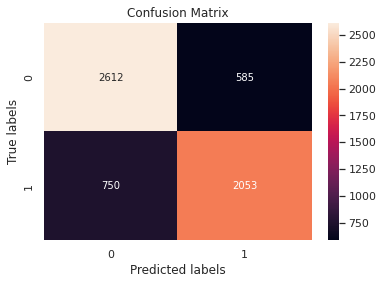

In [ ]:
predictions = pipe_RF_Clf.predict(X_test)
#Calculating Confusion Matrix
CM = confusion_matrix(y_test, predictions)

# drawing confusion matrix
ax= plt.subplot()
sns.heatmap(CM, annot=True, fmt='g', ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

In [ ]:
#Calculating classification Report (precision, recall, f1-score, accuracy) on test set:  

ClassificationReport = classification_report(y_test, predictions)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.78      0.82      0.80      3197
           1       0.78      0.73      0.75      2803

    accuracy                           0.78      6000
   macro avg       0.78      0.77      0.78      6000
weighted avg       0.78      0.78      0.78      6000



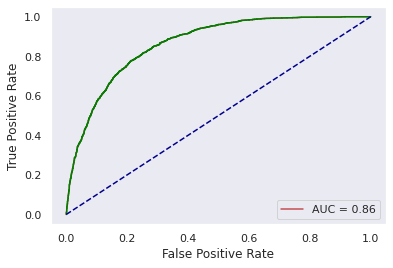

In [ ]:
#calculate and virtualize the roc curve for the test set
fpr, tpr, thresholds = roc_curve(y_test, pipe_RF_Clf.predict_proba(X_test)[:,1])

roc_auc = roc_auc_score(y_test, pipe_RF_Clf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr, tpr, color='green', label='')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.grid()

In [ ]:
#predict and create CSV file for CSV test file
df2 = pd.read_csv('/content/drive/MyDrive/DEBI/Queens/DM/Assignment_3/x_test.csv')
submission = pd.DataFrame()
submission['id'] = df2['id']
submission['label'] = pipe_RF_Clf.predict_proba(df2['text'])[:, 1]

submission.to_csv('No_pre_RF_Random_trial_1.csv', index=False)

#kaggel  0.84884

* as we see from the previous virtualization and test 
* i got 85.9% best score which it's close to my expectation and this model is'nt good between the other models 
* and give me 78% score on test data which is not good
* and give me 86% auc on test data which it's close to my expectation 
* and give me 84.88 % on kaggle which it's so-so

> from all of that, this model not good and this model has the worst results between the three models i will try another model to see if there is any improvement or not



##Trail_4 (LogisticRegression with GridSearch)==>with validation set

> in this trial i will use LogisticRegression Model with GridSearch approach by using pipeline and using tfidfvectorizer with the default hyperparameters and using validation set for training

in this model i expect to give me score around 90% on training and 90% auc on test set

In [ ]:
# step 1: using TfidfVectorizer with default hyperparameters
# step 2: using LR Model
pipe_LR_Clf_2 = Pipeline([('tfidf', TfidfVectorizer()),
                       ('LR_Grid', LogisticRegression(max_iter = 600, random_state=42))
                       ])


#fit the model and print the score the model
pipe_LR_Clf_2.fit(X_train, y_train)
pipe_LR_Clf_2.score(X_train, y_train)

0.873

Validation set

In [ ]:
# Further split the original training set to a train and a validation set
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train, random_state = 42)
# Create a list where train data indices are -1 and validation data indices are 0
# X_train2 (new training set), X_train
split_index = [-1 if x in X_train2.index else 0 for x in X_train.index]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)


> using the GridSearch and validation set for hyperparameters tuning 

In [ ]:
#calculate running time
%%time
#the possiple hyperparameters for tuning
params_VS = {
    "LR_Grid__solver": [ 'lbfgs', 'liblinear', 'saga'],
    "LR_Grid__C": np.arange(0.1, 1, 0.1),
    "LR_Grid__penalty":['l1', 'l2', 'none']
}

#Tune by GridSearch with scoring roc_auc
pipe_LR_Grid_clf_2 = GridSearchCV(pipe_LR_Clf_2, params_VS, n_jobs=-1, cv = pds, verbose=2, scoring="roc_auc")

#fit the gridsearch model
pipe_LR_Grid_clf_2.fit(X_train, y_train)

Fitting 1 folds for each of 81 candidates, totalling 81 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 81.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File

CPU times: user 7.23 s, sys: 670 ms, total: 7.9 s
Wall time: 4min 59s


In [ ]:
#best score and hyperparameter from tunning
print('best score {}'.format(pipe_LR_Grid_clf_2.best_score_))
best_params = pipe_LR_Grid_clf_2.best_params_
print(best_params)

best score 0.8914955277681766
{'LR_Grid__C': 0.9, 'LR_Grid__penalty': 'l2', 'LR_Grid__solver': 'saga'}


In [ ]:
# run pipe with optimized parameters
pipe_LR_Clf_2.set_params(**best_params).fit(X_train, y_train)
pipe_pred = pipe_LR_Clf_2.predict_proba(X_test)

> **Virtualization and report for this model**

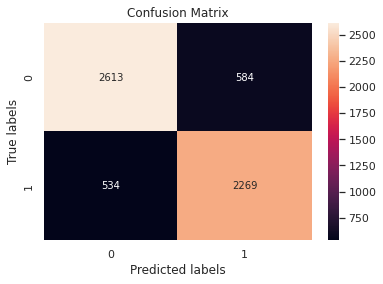

In [ ]:
predictions = pipe_LR_Clf_2.predict(X_test)
#Calculating Confusion Matrix
CM = confusion_matrix(y_test, predictions)

# drawing confusion matrix
ax= plt.subplot()
sns.heatmap(CM, annot=True, fmt='g', ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

In [ ]:
#Calculating classification Report (precision, recall, f1-score, accuracy) on test set:  

ClassificationReport = classification_report(y_test, predictions)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.83      0.82      0.82      3197
           1       0.80      0.81      0.80      2803

    accuracy                           0.81      6000
   macro avg       0.81      0.81      0.81      6000
weighted avg       0.81      0.81      0.81      6000



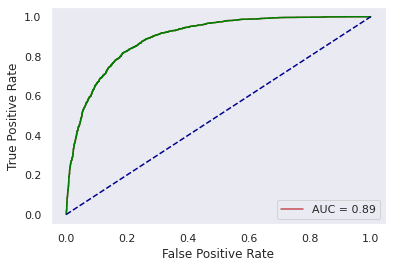

In [ ]:
#calculate and virtualize the roc curve for the test set
fpr, tpr, thresholds = roc_curve(y_test, pipe_LR_Clf_2.predict_proba(X_test)[:,1])

roc_auc = roc_auc_score(y_test, pipe_LR_Clf_2.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr, tpr, color='green', label='')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.grid()

In [ ]:
#predict and create CSV file for CSV test file
df2 = pd.read_csv('/content/drive/MyDrive/DEBI/Queens/DM/Assignment_3/x_test.csv')
submission = pd.DataFrame()
submission['id'] = df2['id']
submission['label'] = pipe_LR_Clf_2.predict_proba(df2['text'])[:, 1]

submission.to_csv('No_pre_LR_Grid_trial_1_VS.csv', index=False)

#kaggel  0.86157

* as we see from the previous virtualization and test 
* i got 89.1% best score which it's close to my expectation and good and this is the highest one i got
* and give me 81% score on test data which is good
* and give me 89% auc on test data which it's close to my expectation and good and this is better than the previous one 
* and give me 86.157 % on kaggle which it's the best one untill now

> from all of that this model not bad and it's good model also not bad i will try another models with another data preprocessing to see if there is any improvement or not



#Second Trial For Data Preprocessing

#Load the data

In [ ]:
#read the data into data frame
df_2T = pd.read_csv('/content/drive/MyDrive/DEBI/Queens/DM/Assignment_3/xy_train.csv')
#display the first 5 rows of dataframe
df_2T.head()

#Preprocessing_2

>Overview
 * for this trial i will do a few things like  i will check the unique values of target column and handle this column by remove the values that are out of range and then i will check for duplicates and handeling that by remove this rows which has duplicate and then i will use tfidfvectors to handle the another things by using the default hyperparameters

##Handel the null values

i will check if there ara any null values or not to handle that problem if exist

In [ ]:
#check for the columns which have the heights nun values
df_2T.isnull().sum().sort_values(ascending=False)

id       0
text     0
label    0
dtype: int64

as we see the data has zero null values

In [ ]:
#virtualize the data correlation
corr = df_2T.corr()

corr.style.background_gradient(cmap="Spectral")

,id,label
id,1.000000,0.000687
label,0.000687,1.000000


##Handling the target column

Checking the uniques values for label column because the range of label column must be zero or one

In [ ]:
#print the unique values
df_2T['label'].value_counts()

0    32172
1    27596
2      232
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


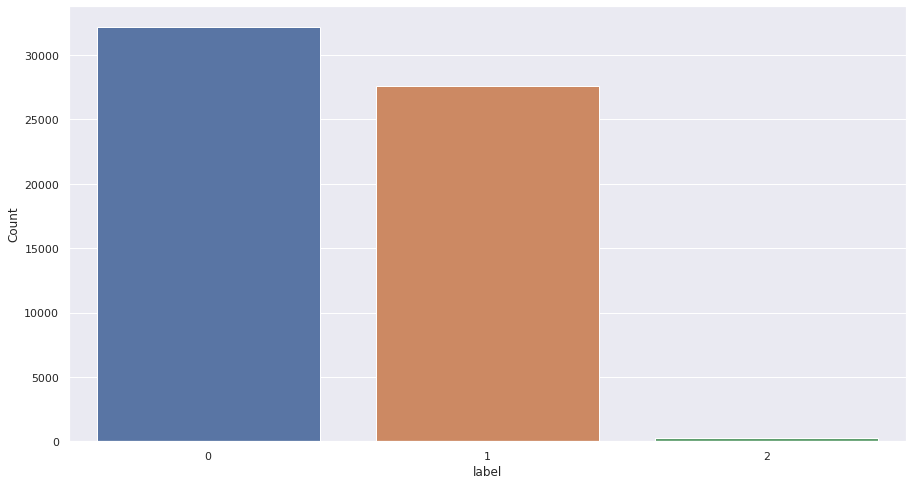

In [ ]:
# checking for distribution of label column before handling
fig, ax = plt.subplots(figsize = (15, 8))
sns.countplot('label', data = df_2T, order = df_2T['label'].value_counts().index, ax = ax)
ax.set(xlabel='label', ylabel='Count')
plt.show()

as we see we have 3 unique values for label column so i will convert all label value (2) to be (1)

in the previous trial i convert 2 to 1 and this approach give my good score by using Logistic Regression but now in this trial i will drop every row has label = 2


Delete all rows which has target = 2

In [ ]:
df_2T = df_2T[df_2T.label != 2]

In [ ]:
#checking for the distribution of grade_bad
df_2T['label'].value_counts()

0    32172
1    27596
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


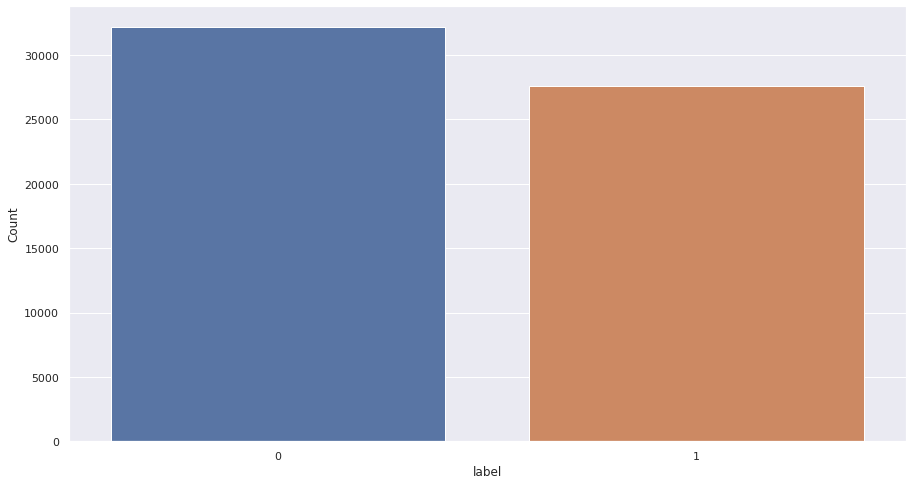

In [ ]:
# checking for distribution of new_label column after handling
fig, ax = plt.subplots(figsize = (15, 8))
sns.countplot('label', data = df_2T, order = df_2T['label'].value_counts().index, ax = ax)
ax.set(xlabel='label', ylabel='Count')
plt.show()

In [ ]:
#Checking if the new_label is balance or not
df_2T["label"].value_counts(normalize=True)

0    0.538281
1    0.461719
Name: label, dtype: float64

now we have new target column with values (0, 1)

as we see the data is balance which is good

##handling the duplication

In [ ]:
#describe the text column
df_2T['text'].describe()

count                                                 59768
unique                                                59413
top       /r/Fakehistoryporn subscribers as they attempt...
freq                                                     14
Name: text, dtype: object

as we see we have 59645 unique values out of 60000 rows so in the first trial i let them and the results was good but now i will remove them and compare the results

Remove all rows which duplicated

In [ ]:
#print the sum number of duplicated values in text column
df_2T['text'].duplicated().sum()

355

In [ ]:
#print the duplicated rows
df_2T[df_2T['text'].duplicated()]

,id,text,label
417,213389,Virginia Governor signs historic coal ash clea...,1
579,169958,"Joni Ernst, Mike Lee roll out conservative pai...",1
617,127721,Scientists from Purdue University have devised...,1
712,86881,Gov. Laura Kelly attracts crowd for signing of...,1
1095,410748,"Chinese-American architect I. M. Pei, one of t...",1
...,...,...,...
58638,547738,This framed photo of a slice of toast that loo...,0
58775,210611,New Department Of Agriculture Study Finds 85% ...,0
58849,213125,Committee approves a bill to place Helen Kelle...,1
58934,170699,The less Americans know about Ukraine鈥檚 locati...,1


Remove the duplicated rows

In [ ]:
#Remove the duplicated rows
df_2T.drop_duplicates('text',inplace = True)

#split the data to features and target

**target data**

In [ ]:
# but the new_label column in Y which is the target value
Y_2T = df_2T['label']
print(Y_2T.shape)

(59413,)


**Features Data**

In [ ]:
# but the new_label column in Y which is the target value
X_2T = df_2T['text']
#print the shape for features
print(X_2T.shape)

(59413,)


Split the training data into training set and test set to test results local 

In [ ]:
#split the training set inot 90% training and 10% test
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2T, Y_2T, test_size=0.1, random_state=42)

print('X_train:', X_train_2.shape)
print('X_test:', X_test_2.shape)
print('y_train:', y_train_2.shape)
print('y_test:', y_test_2.shape)

X_train: (53471,)
X_test: (5942,)
y_train: (53471,)
y_test: (5942,)


#Pipe Models

##Trail_1 (XGBClassifier)

> in this trial i will use XGBClassifier with pipeline and using tfidfvectorizer with the default hyperparameters

in this model i expect to give me score around 90% on training and 90% auc on test set

In [ ]:
# step 1: using TfidfVectorizer with default hyperparameters
# step 2: using XGBClassifier
pipe_XGB_Clf_2 = Pipeline(
                        [('tfidf', TfidfVectorizer()),
                        ('XGB', XGBClassifier(objective='binary:logistic', subsample = 0.7, colsample_bytree =  0.8, n_estimators = 200, max_depth = 16, random_state=42))
                        ])

#fit the model and print the score the model
pipe_XGB_Clf_2.fit(X_train_2, y_train_2)  
pipe_XGB_Clf_2.score(X_train_2, y_train_2)

0.8902769725645677

> **Virtualization and report for this model**

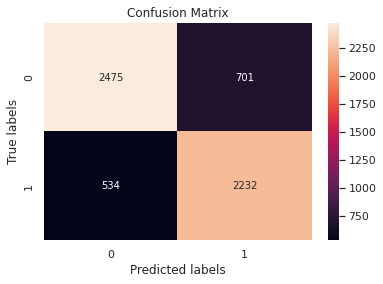

In [ ]:
predictions_2 = pipe_XGB_Clf_2.predict(X_test_2)
#Calculating Confusion Matrix
CM = confusion_matrix(y_test_2, predictions_2)

# drawing confusion matrix
ax= plt.subplot()
sns.heatmap(CM, annot=True, fmt='g', ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

In [ ]:
#Calculating classification Report (precision, recall, f1-score, accuracy) on test set:  

ClassificationReport = classification_report(y_test_2, predictions_2)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.82      0.78      0.80      3176
           1       0.76      0.81      0.78      2766

    accuracy                           0.79      5942
   macro avg       0.79      0.79      0.79      5942
weighted avg       0.79      0.79      0.79      5942



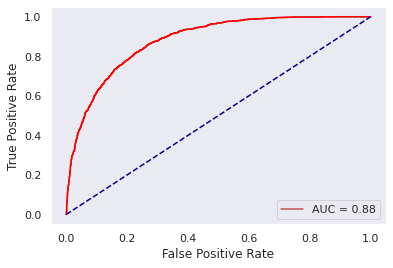

In [ ]:
#calculate and virtualize the roc curve for the test set
fpr, tpr, thresholds = roc_curve(y_test_2, pipe_XGB_Clf_2.predict_proba(X_test_2)[:,1])

roc_auc = roc_auc_score(y_test_2, pipe_XGB_Clf_2.predict_proba(X_test_2)[:,1])
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr, tpr, color='red', label='')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.grid()

In [ ]:
#predict and create CSV file for CSV test file
df2 = pd.read_csv('/content/drive/MyDrive/DEBI/Queens/DM/Assignment_3/x_test.csv')
submission = pd.DataFrame()
submission['id'] = df2['id']
submission['label'] = pipe_XGB_Clf_2.predict_proba(df2['text'])[:, 1]

submission.to_csv('No_pre_XGB_trial_2.csv', index=False)

#kaggel  0.84176

* as we see from the previous virtualization and test 
* i got 89% score which it's close to my expectation and good 
* and give me 79% score on test data 
* and give me 88% auc on test data which it's close to my expectation and good
* and give me 84.176 % on kaggle

> so from all of this this model with this preprocessing is better than the XGBClassifier on the previous Data Preprocessing

> from all of that this model not bad and also not good i will try another model to see if there is any improvement or not



##Trail_2 (LogisticRegression with GridSearch) ==> ValidationSet

> in this trial i will use LogisticRegression Model with GridSearch approach by using pipeline and using tfidfvectorizer with the default hyperparameters

in this model i expect to give me score around 90% on training and 90% auc on test set

In [ ]:
# step 1: using TfidfVectorizer with default hyperparameters
# step 2: using LR Model
pipe_LR_Clf_2 = Pipeline([('tfidf', TfidfVectorizer()),
                       ('LR_Grid', LogisticRegression(max_iter = 600, random_state=42))
                       ])


#fit the model and print the score the model
pipe_LR_Clf_2.fit(X_train_2, y_train_2)
pipe_LR_Clf_2.score(X_train_2, y_train_2)

0.875409100259954

i will test this on kaggle without using GridSearch and validation set to se the results

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/DEBI/Queens/DM/Assignment_3/x_test.csv')
submission = pd.DataFrame()
submission['id'] = df2['id']
submission['label'] = pipe_LR_Clf_2.predict_proba(df2['text'])[:, 1]

submission.to_csv('No_pre_LR_Grid_trial_2_no_Gride.csv', index=False)

#kaggel  0.85998

* Score 87.5%
* kaggle Score 85.9%
as we see the model is better than many model but it is not the best one

now i will use the Validation set and GridSearch

> using the GridSearch for hyperparameters tuning 

In [ ]:
# Further split the original training set to a train and a validation set
X_train2, X_val, y_train2, y_val = train_test_split(X_train_2, y_train_2, test_size = 0.2, stratify = y_train_2, random_state = 42)
# Create a list where train data indices are -1 and validation data indices are 0
# X_train2 (new training set), X_train
split_index_2 = [-1 if x in X_train2.index else 0 for x in X_train_2.index]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index_2)


In [ ]:
#calculate the running time
%%time
# define parameter space to test # runtime 19min
params_2 = {
    "LR_Grid__solver": [ 'lbfgs', 'liblinear', 'saga'],
    "LR_Grid__C": np.arange(0.1, 1, 0.1),
    "LR_Grid__penalty":['l1', 'l2', 'none']
}

#Tune by GridSearch with scoring roc_auc
pipe_LR_Grid_clf_2 = GridSearchCV(pipe_LR_Clf_2, params_2, n_jobs=-1, cv = pds, verbose=2, scoring="roc_auc")
#fit the gridsearch model
pipe_LR_Grid_clf_2.fit(X_train_2, y_train_2)

Fitting 1 folds for each of 81 candidates, totalling 81 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 81.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File

CPU times: user 9.72 s, sys: 4.18 s, total: 13.9 s
Wall time: 4min 48s


In [ ]:
#best score and hyperparameter from tunning
print('best score {}'.format(pipe_LR_Grid_clf_2.best_score_))
best_params_2 = pipe_LR_Grid_clf_2.best_params_
print(best_params_2)

best score 0.887772259292219
{'LR_Grid__C': 0.9, 'LR_Grid__penalty': 'l2', 'LR_Grid__solver': 'lbfgs'}


In [ ]:
# run pipe with best hyperparameters
pipe_LR_Clf_2.set_params(**best_params_2).fit(X_train_2, y_train_2)
pipe_pred_2 = pipe_LR_Clf_2.predict_proba(X_test_2)

> **Virtualization and report for this model**

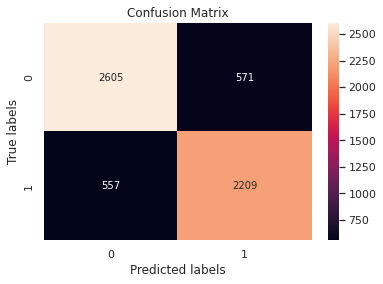

In [ ]:
predictions_2 = pipe_LR_Clf_2.predict(X_test_2)
#Calculating Confusion Matrix
CM = confusion_matrix(y_test_2, predictions_2)

# drawing confusion matrix
ax= plt.subplot()
sns.heatmap(CM, annot=True, fmt='g', ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

In [ ]:
#Calculating classification Report (precision, recall, f1-score, accuracy) on test set:  

ClassificationReport = classification_report(y_test_2, predictions_2)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      3176
           1       0.79      0.80      0.80      2766

    accuracy                           0.81      5942
   macro avg       0.81      0.81      0.81      5942
weighted avg       0.81      0.81      0.81      5942



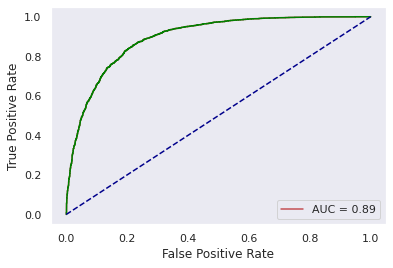

In [ ]:
#calculate and virtualize the roc curve for the test set
fpr, tpr, thresholds = roc_curve(y_test_2, pipe_LR_Clf_2.predict_proba(X_test_2)[:,1])

roc_auc = roc_auc_score(y_test_2, pipe_LR_Clf_2.predict_proba(X_test_2)[:,1])
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr, tpr, color='green', label='')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.grid()

In [ ]:
#predict and create CSV file for CSV test file
df2 = pd.read_csv('/content/drive/MyDrive/DEBI/Queens/DM/Assignment_3/x_test.csv')
submission = pd.DataFrame()
submission['id'] = df2['id']
submission['label'] = pipe_LR_Clf_2.predict_proba(df2['text'])[:, 1]

submission.to_csv('No_pre_LR_Grid_trial_VS2.csv', index=False)

#kaggel  0.86031

* as we see from the previous virtualization and test 
* i got 87.5% best score which it's not close to my expectation and good 
* and give me 81% score on test data which is good
* and give me 89% auc on test data which it's close to my expectation and good and this is better than the previous one 
* and give me 86.03 % on kaggle which is good but this is the second best score until now

> from all of that this model not bad and it's good model also not bad i will try another model to see if there is any improvement or not



##Trail_3 (RandomForest with RandomSearch)

> in this trial i will use RandomForest Model with RandomSearch approach by using pipeline and using tfidfvectorizer with the default hyperparameters

in this model i expect to give me score around 85% on training and 85% auc on test set

In [ ]:
# step 1: using TfidfVectorizer with default hyperparameters
# step 2: using RF Model
pipe_RF_Clf_2 = Pipeline([('tfidf', TfidfVectorizer()),
                       ('RF_Random',RandomForestClassifier(random_state = 3))
                       ])


# pipe_LR_Clf.fit(X_train, y_train)
# pipe_LR_Clf.score(X_train, y_train)

In [ ]:
%%time
# define parameter space to test # runtime 19min
randomForest_params = {
    # Number of trees in random forest
    'RF_Random__n_estimators': [100, 200, 400, 500, 700, 1000, 2000],
    # Maximum number of levels in tree
    'RF_Random__max_depth' : [10, 20, 40, 50, 60, 70],
    # Number of features to consider at every split
    'RF_Random__max_features': ['auto', 'sqrt']
    
}
#Tune by GridSearch with scoring roc_auc
pipe_RF_Random_clf_2 = RandomizedSearchCV(pipe_RF_Clf_2, randomForest_params, n_iter = 10, n_jobs=-1, cv = 2, random_state=42, verbose=2, scoring="roc_auc")

#fit the gridsearch model
pipe_RF_Random_clf_2.fit(X_train_2, y_train_2)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
CPU times: user 2min 36s, sys: 820 ms, total: 2min 37s
Wall time: 9min 15s


In [ ]:
#best score and hyperparameter from tunning
print('best score {}'.format(pipe_RF_Random_clf_2.best_score_))
best_params_2 = pipe_RF_Random_clf_2.best_params_
print(best_params_2)

best score 0.860384910514205
{'RF_Random__n_estimators': 500, 'RF_Random__max_features': 'auto', 'RF_Random__max_depth': 70}


In [ ]:
# run pipe with optimized parameters
pipe_RF_Clf_2.set_params(**best_params_2).fit(X_train_2, y_train_2)
pipe_pred_RF_2 = pipe_RF_Clf_2.predict_proba(X_test_2)

> **Virtualization and report for this model**

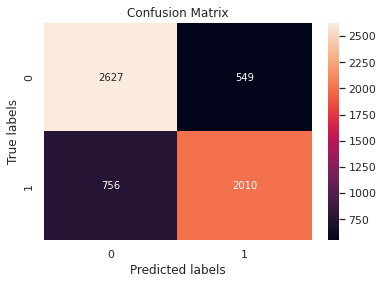

In [ ]:
predictions_2 = pipe_RF_Clf_2.predict(X_test_2)
#Calculating Confusion Matrix
CM = confusion_matrix(y_test_2, predictions_2)

# drawing confusion matrix
ax= plt.subplot()
sns.heatmap(CM, annot=True, fmt='g', ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

In [ ]:
#Calculating classification Report (precision, recall, f1-score, accuracy) on test set:  

ClassificationReport = classification_report(y_test_2, predictions_2)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.78      0.83      0.80      3176
           1       0.79      0.73      0.75      2766

    accuracy                           0.78      5942
   macro avg       0.78      0.78      0.78      5942
weighted avg       0.78      0.78      0.78      5942



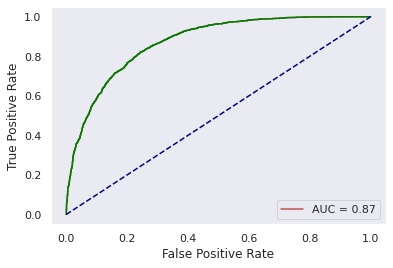

In [ ]:
#calculate and virtualize the roc curve for the test set
fpr, tpr, thresholds = roc_curve(y_test_2, pipe_RF_Clf_2.predict_proba(X_test_2)[:,1])

roc_auc = roc_auc_score(y_test_2, pipe_RF_Clf_2.predict_proba(X_test_2)[:,1])
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr, tpr, color='green', label='')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.grid()

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/DEBI/Queens/DM/Assignment_3/x_test.csv')
submission = pd.DataFrame()
submission['id'] = df2['id']
submission['label'] = pipe_LR_Clf_2.predict_proba(df2['text'])[:, 1]

submission.to_csv('No_pre_RF_Random_trial_2.csv', index=False)

#kaggel  0.83795

* as we see from the previous virtualization and test 
* i got 86.03% best score which it's close to my expectation and good 
* and give me 78% score on test data which is good
* and give me 87% auc on test data which it's close to my expectation and good and this is better than the previous one 
* and give me 83.79 % on kaggle which it's good

> from all of that this model not bad and it's good model also not bad i will try another model to see if there is any improvement or not



* After Two Trials for Data preprocessing there are differents results but the best one is LR Model in First Trial for data preprocessing and 
* there is another observation there are some model was good in first trial become not good in the second trial and vice versa

**Now i will use another approach for data preprocessing to see if the results will improve or  not**

#Third Trial For Data Preprocessing


> ### Vectorization

> In basic terms, Vectorization is the process of converting text into numerical representation which are also called embeddings. Since, the computers are not as intelligent as us (till now atleast ;), they can't understand textual data, so to make our data understandable to a computer, we first convert it to a numerical format.

> There are various techniques for text vectorization like:-



>*   Bag of Words
*   Count Vectorizer
*   TF-IDF Vectorizer

> Here, we're gonna use the TF-IDF Vectorizer approach. So, TF-IDF is an acronym for Term Frequency - Inverse Document Frequency.


> *   TF makes sure to give high score to the word that appears frequently.
*   IDF makes sure to give low score to the word if it appears pretty frequently in documents (not a unique identifier).

> So, the amalgamation of TF * IDF is how the score is calculated for this vectorizer.



> ## Stemming

> ### In the previous prepeocessed_trial_1 we used lemmatization but at this trial we will use the Stemmer .

> The difference between stemming and lemmatization is that stemming is faster as it cuts words without knowing the context, while lemmatization is slower as it knows the context of words before processing.

> See this [Link](https://www.guru99.com/stemming-lemmatization-python-nltk.html)

> [Source]: Kareem Gamal Mahmoud (21KGMM) ==> he is my classmate

#Load the data

In [16]:
#read the data into data frame
df_3T = pd.read_csv('/content/drive/MyDrive/DEBI/Queens/DM/Assignment_3/xy_train.csv')
#display the first 5 rows of dataframe
df_3T.head()

,id,text,label
0,265723,A group of friends began to volunteer at a hom...,0
1,284269,British Prime Minister @Theresa_May on Nerve A...,0
2,207715,"In 1961, Goodyear released a kit that allows P...",0
3,551106,"Happy Birthday, Bob Barker! The Price Is Right...",0
4,8584,"Obama to Nation: 聙""Innocent Cops and Unarmed Y...",0


In [17]:
df_Test = pd.read_csv('/content/drive/MyDrive/DEBI/Queens/DM/Assignment_3/x_test.csv')
df_Test.head()

,id,text
0,0,stargazer
1,1,yeah
2,2,PD: Phoenix car thief gets instructions from Y...
3,3,"As Trump Accuses Iran, He Has One Problem: His..."
4,4,"""Believers"" - Hezbollah 2011"


#Preprocessing_3

>Overview
* In this trial I will try a new approach for data preprocessing i will use the first two approach for data preprocessing with this trial and add some new processes

##Handel the null values

i will check if there ara any null values or not to handle that problem if exist

In [18]:
#check for the columns which have the heights nun values
df_3T.isnull().sum().sort_values(ascending=False)

id       0
text     0
label    0
dtype: int64

as we see the data has zero null values

In [19]:
#virtualize the data correlation
corr = df_3T.corr()

corr.style.background_gradient(cmap="Spectral")

,id,label
id,1.000000,0.000687
label,0.000687,1.000000


##Handling the target column

Checking the uniques values for label column because the range of label column must be zero or one

In [20]:
#print the unique values
df_3T['label'].value_counts()

0    32172
1    27596
2      232
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


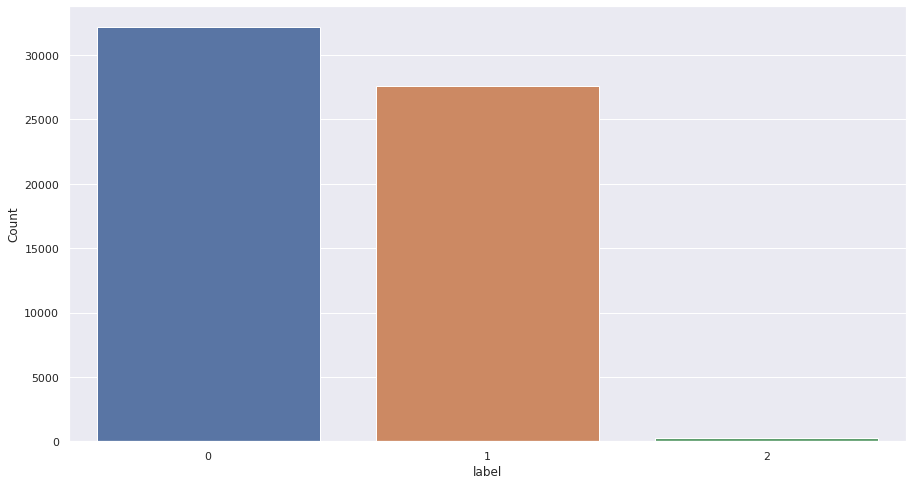

In [21]:
# checking for distribution of label column before handling
fig, ax = plt.subplots(figsize = (15, 8))
sns.countplot('label', data = df_3T, order = df_3T['label'].value_counts().index, ax = ax)
ax.set(xlabel='label', ylabel='Count')
plt.show()

as we see we have 3 unique values for label column so i will convert all label value (2) to be (1)

i will create new column (grade_bad) has all values 0 then check on the label column then i will update the values in grade_bad column
* if label column has value 0 then i will fill grade_bad with (zero)
* else if the label column has value more than (zero) i will fill grade_bad with (one)

In [22]:
#create new column has the new target data after handling
df_3T["new_label"] = 0
df_3T.loc[df_3T["label"] == 0, "new_label"] = 0
df_3T.loc[df_3T["label"] > 0, "new_label"] = 1

In [23]:
#checking for the distribution of grade_bad
df_3T['new_label'].value_counts()

0    32172
1    27828
Name: new_label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


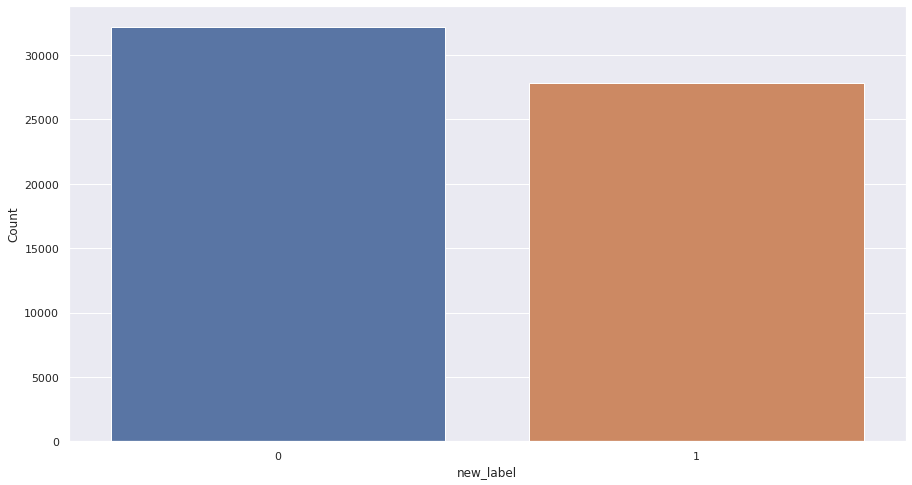

In [24]:
# checking for distribution of new_label column after handling
fig, ax = plt.subplots(figsize = (15, 8))
sns.countplot('new_label', data = df_3T, order = df_3T['new_label'].value_counts().index, ax = ax)
ax.set(xlabel='new_label', ylabel='Count')
plt.show()

now we have new target column with values (0, 1)

In [25]:
#Checking if the new_label is balance or not
df_3T["new_label"].value_counts(normalize=True)

0    0.5362
1    0.4638
Name: new_label, dtype: float64

as we see the data is balance which is good

##handling the duplication

In [26]:
#describe the text column
df_3T['text'].describe()

count                                                 60000
unique                                                59645
top       /r/Fakehistoryporn subscribers as they attempt...
freq                                                     14
Name: text, dtype: object

as we see we have 59645 unique values out of 60000 rows so in the first trial i let them and the results was good but now i will remove them and compare the results

In [27]:
df_3T['text'].duplicated().sum()

355

In [28]:
df_3T[df_3T['text'].duplicated()]

,id,text,label,new_label
417,213389,Virginia Governor signs historic coal ash clea...,1,1
579,169958,"Joni Ernst, Mike Lee roll out conservative pai...",1,1
617,127721,Scientists from Purdue University have devised...,1,1
712,86881,Gov. Laura Kelly attracts crowd for signing of...,1,1
1095,410748,"Chinese-American architect I. M. Pei, one of t...",1,1
...,...,...,...,...
58638,547738,This framed photo of a slice of toast that loo...,0,0
58775,210611,New Department Of Agriculture Study Finds 85% ...,0,0
58849,213125,Committee approves a bill to place Helen Kelle...,1,1
58934,170699,The less Americans know about Ukraine鈥檚 locati...,1,1


In [29]:
df_3T.drop_duplicates('text',inplace = True)

In [30]:
#describe the text column
df_3T['text'].describe()

count                                                 59645
unique                                                59645
top       A group of friends began to volunteer at a hom...
freq                                                      1
Name: text, dtype: object

##Handeling Text Column

In [31]:
# Downloading some packages
nltk.download("stopwords")
stopwords_ = stopwords.words('english')
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

**remove some special char and links and spaces and punctuation and convert the words to lowe case and drop the stopwords**

In [32]:
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()
#remove some special char and links and spaces and punctuation
stemmer = SnowballStemmer(language='english')
def simple_clear(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z]", ' ', text)
    text = re.sub(r'<.*?>','',text)
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)
    text = re.sub(r'\[|\(.*\]|\)','', text) 
    text = re.sub(r"(\\W)"," ",text) 
    text = re.sub(r'\S*\d\S*\s*','', text)  
    text = text.split()
    text = [stemmer.stem(word) for word in text if not word in set(stopwords_)]
    text = ' '.join(text)
    return text

In [33]:
#apply the simple_clear Function on text column and create a new column called clean_text column
df_3T['clean_text'] = df_3T['text'].apply(simple_clear)

We need also to apply the 'simple_clear' function on the test data. to handle this data to be the same as training data

apply the same function on test data

In [34]:
df_Test['clean_text'] = df_Test['text'].apply(simple_clear)

In [35]:
#describe the text column
df_3T.describe(include=[object, int])

,id,text,label,new_label,clean_text
count,59645.000000,59645,59645.000000,59645.000000,59645
unique,NaN,59645,NaN,NaN,59559
top,NaN,A group of friends began to volunteer at a hom...,NaN,NaN,r fakehistoryporn subscrib attempt read seri b...
freq,NaN,1,NaN,NaN,7
mean,280266.807863,NaN,0.468237,0.464347,NaN
std,162608.743146,NaN,0.506729,0.498731,NaN
min,0.000000,NaN,0.000000,0.000000,NaN
25%,138654.000000,NaN,0.000000,0.000000,NaN
50%,279878.000000,NaN,0.000000,0.000000,NaN
75%,421257.000000,NaN,1.000000,1.000000,NaN


##handeling Cleen_text Column

Check for duplications

In [36]:
#print the sum number of duplication row on cleen_text column
df_3T['clean_text'].duplicated().sum()

86

as we see we have 86 rows duplicated so i will drop this rows

In [37]:
df_3T[df_3T['clean_text'].duplicated()]

,id,text,label,new_label,clean_text
272,505455,A woman was nearly killed after teens threw a ...,1,1,woman near kill teen threw lbs frozen turkey w...
1313,308899,"You mean, let me understand this cause, ya kno...",0,0,mean let understand caus ya know mayb littl fu...
4263,274858,"""Can you any longer resist the call?"" A 1915 B...",0,0,longer resist call british poster depart recru...
5153,254496,My dad (far left) in Vietnam in 1971. Didn't k...,0,0,dad far left vietnam know photo exist came acr...
5347,541264,My Dad (front) in Vietnam in 1971. Didn't know...,0,0,dad front vietnam know photo exist came across...
...,...,...,...,...,...
57999,187145,"Smoke from the Detwiler Fire in Mariposa, Cali...",0,0,smoke detwil fire mariposa california look lik...
58315,413827,Me (Centre) after seeing another 鈥淢y Dad in Vi...,0,0,centr see anoth dad vietnam shitpost march color
58954,54937,Disgusting: ISIS Just Released A 2-Star Review...,2,1,disgust isi releas star review n aeroplan sea
59093,505566,I Used To Think All Terrorists Were Muslim. Th...,2,1,use think terrorist muslim saw peed cruis control


as we see we have a duplicate values in Cleen_text column so i will drop that duplicates and then create a pipeline with tfidfvectorize to train the model

drop the duplication rows

In [38]:
df_3T.drop_duplicates('clean_text',inplace = True)

In [39]:
#describe the text column
df_3T['clean_text'].describe()

count                                                 59559
unique                                                59559
top       group friend began volunt homeless shelter nei...
freq                                                      1
Name: clean_text, dtype: object

In [40]:
df_3T.shape

(59559, 5)

#split the data to features and target

**target data**

In [41]:
Y_3T = df_3T['new_label']
print(Y_3T.shape)

(59559,)


**Features Data**

this data will change depend on the data preprocessing i did or i will do

In [42]:
X_3T = df_3T['clean_text']
#print the shape for features
print(X_3T.shape)

(59559,)


Split the training data into training set and test set to test results local 

In [43]:
#split the training set inot 90% training and 10% test
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3T, Y_3T, test_size=0.1, random_state=42)

print('X_train:', X_train_3.shape)
print('X_test:', X_test_3.shape)
print('y_train:', y_train_3.shape)
print('y_test:', y_test_3.shape)

X_train: (53603,)
X_test: (5956,)
y_train: (53603,)
y_test: (5956,)


#Pipe Models

##Trail_1 (XGBClassifier, RandomSearch)

> in this trial i will use XGBClassifier with pipeline and using tfidfvectorizer with different hyperparameters by using RandomSearch tuning


in this model i expect to give me score around 80% on training and 80% auc on test set

In [ ]:
# step 1: using TfidfVectorizer with default hyperparameters
# step 2: using XGBClassifier
pipe_XGB_Clf_3 = Pipeline(
                        [('tfidf', TfidfVectorizer()),
                        ('XGB_3', XGBClassifier(objective='binary:logistic', random_state=42))
                        ])
#fit the model and print the score the model
pipe_XGB_Clf_3.fit(X_train_3, y_train_3)  
pipe_XGB_Clf_3.score(X_train_3, y_train_3)

0.6802231218401955

In [ ]:
# XGB hyperparameters
XGB_3_params = {
    "tfidf__ngram_range": [(1, 2), (1, 3)],
    "tfidf__max_df": np.arange(0.3, 0.8),
    "tfidf__min_df": np.arange(5, 100),
    'XGB_3__n_estimators': [20, 30, 50, 100, 200, 220],  
    'XGB_3__max_depth':[10, 16, 20, 30], 
    "XGB_3__subsample": np.arange(0.4, 1, 0.1), 
    "XGB_3__colsample_bytree": np.arange(0.4, 1, 0.1)
}

In [ ]:
%%time
pipe_XGB_Random_clf_3 = RandomizedSearchCV(pipe_XGB_Clf_3, XGB_3_params, n_iter = 10, n_jobs=-1, cv = 3, random_state=42, verbose=2, scoring="roc_auc")
pipe_XGB_Random_clf_3.fit(X_train_3, y_train_3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 31.4 s, sys: 572 ms, total: 31.9 s
Wall time: 5min 17s


In [ ]:
print('best score {}'.format(pipe_XGB_Random_clf_3.best_score_))
best_params_3 = pipe_XGB_Random_clf_3.best_params_
print(best_params_3)

best score 0.8289219394011734
{'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 54, 'tfidf__max_df': 0.3, 'XGB_3__subsample': 0.7999999999999999, 'XGB_3__n_estimators': 200, 'XGB_3__max_depth': 10, 'XGB_3__colsample_bytree': 0.7}


In [ ]:
# run pipe with optimized parameters
pipe_XGB_Clf_3.set_params(**best_params_3).fit(X_train_3, y_train_3)
pipe_pred_RF_2 = pipe_XGB_Clf_3.predict_proba(X_test_3)

> **Virtualization and report for this model**

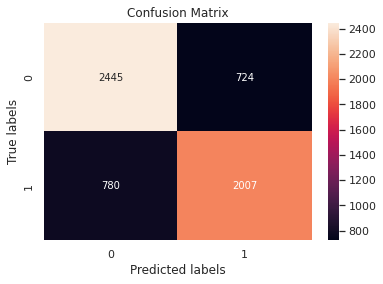

In [ ]:
#using the training model to predict the test set
predictions_3 = pipe_XGB_Clf_3.predict(X_test_3)
#Calculating Confusion Matrix
CM = confusion_matrix(y_test_3, predictions_3)

# drawing confusion matrix
ax= plt.subplot()
sns.heatmap(CM, annot=True, fmt='g', ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

In [ ]:
#Calculating classification Report (precision, recall, f1-score, accuracy) on test set:  

ClassificationReport = classification_report(y_test_3, predictions_3)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.76      0.77      0.76      3169
           1       0.73      0.72      0.73      2787

    accuracy                           0.75      5956
   macro avg       0.75      0.75      0.75      5956
weighted avg       0.75      0.75      0.75      5956



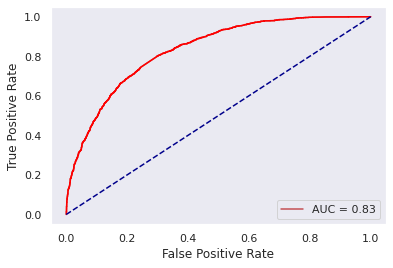

In [ ]:
#calculate and virtualize the roc curve for the test set
fpr, tpr, thresholds = roc_curve(y_test_3, pipe_XGB_Clf_3.predict_proba(X_test_3)[:,1])

roc_auc = roc_auc_score(y_test_3, pipe_XGB_Clf_3.predict_proba(X_test_3)[:,1])
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr, tpr, color='red', label='')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.grid()

In [ ]:
#predict and create CSV file for CSV test file
df2 = pd.read_csv('/content/drive/MyDrive/DEBI/Queens/DM/Assignment_3/x_test.csv')
submission = pd.DataFrame()
submission['id'] = df2['id']
submission['label'] = pipe_XGB_Clf_3.predict_proba(df_Test['clean_text'])[:, 1]

submission.to_csv('No_pre_XGB_RandomS_trial_3.csv', index=False)

#kaggel  0.8176

* as we see from the previous virtualization and test 
* i got 82.8% score which it's close to my expectation and good 
* and give me 75% score on test data 
* and give me 83% auc on test data which it's close to my expectation and bad
* and give me 81.7 % on kaggle

> from all of that this model the worst model i used untill now



##In this part I will use a analyzer='word' and analyzer='char'

###Trail_2 (LogisticRegression with RandomSearch, 'word', validationset)

> in this trial i will use LogisticRegression Model with RandomSearch approach by using pipeline and using tfidfvectorizer with **word** analyzer and different hyperparameters

in this model i expect to give me score around 88% on training and 88% auc on test set

In [ ]:
# step 1: using TfidfVectorizer with analyzer='word'
# step 2: using LR Model
pipe_LR_Clf_3 = Pipeline([('tfidf', TfidfVectorizer(analyzer='word')),
                       ('LR_Grid', LogisticRegression(max_iter = 600, random_state=42))
                       ])


pipe_LR_Clf_3.fit(X_train_3, y_train_3)
pipe_LR_Clf_3.score(X_train_3, y_train_3)

0.8425834374941701

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/DEBI/Queens/DM/Assignment_3/x_test.csv')
submission = pd.DataFrame()
submission['id'] = df2['id']
submission['label'] = pipe_LR_Clf_3.predict_proba(df_Test['clean_text'])[:, 1]

submission.to_csv('No_pre_LR_Grid_trial_3_no_Gride_word.csv', index=False)

#kaggel  0.83444

as we when i test this on kaggle that gives me 83.4% which is not bad now i will use RandomSearch

> using the RandomSearch and Validation Set for hyperparameters tuning 

In [ ]:
# Further split the original training set to a train and a validation set
X_train2, X_val, y_train2, y_val = train_test_split(X_train_3, y_train_3, test_size = 0.2, stratify = y_train_3, random_state = 42)
# Create a list where train data indices are -1 and validation data indices are 0
# X_train2 (new training set), X_train
split_index_2 = [-1 if x in X_train2.index else 0 for x in X_train_3.index]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index_2)


In [ ]:
%%time
# define parameter space to test # runtime 19min
params_3 = {
    "tfidf__ngram_range": [(1, 2), (1, 3)],
    "tfidf__max_df": np.arange(0.3, 0.8),
    "tfidf__min_df": np.arange(5, 100),
    "LR_Grid__solver": [ 'lbfgs', 'liblinear', 'saga'],
    "LR_Grid__C": np.arange(0.1, 1, 0.1),
    "LR_Grid__penalty":['l1', 'l2', 'none']
}
pipe_LR_RS_clf_4 = RandomizedSearchCV(pipe_LR_Clf_3, params_3, n_iter = 50, n_jobs=-1, cv = pds, random_state=42, verbose=2, scoring="roc_auc")
pipe_LR_RS_clf_4.fit(X_train_3, y_train_3)

Fitting 1 folds for each of 50 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
11 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File

CPU times: user 6.97 s, sys: 524 ms, total: 7.49 s
Wall time: 2min 47s


In [ ]:
print('best score {}'.format(pipe_LR_RS_clf_4.best_score_))
best_params_2 = pipe_LR_RS_clf_4.best_params_
print(best_params_2)

best score 0.8627372543225298
{'tfidf__ngram_range': (1, 3), 'tfidf__min_df': 28, 'tfidf__max_df': 0.3, 'LR_Grid__solver': 'lbfgs', 'LR_Grid__penalty': 'l2', 'LR_Grid__C': 0.6}


In [ ]:
# run pipe with optimized parameters
pipe_LR_Clf_3.set_params(**best_params_2).fit(X_train_3, y_train_3)
pipe_pred_2 = pipe_LR_Clf_3.predict_proba(X_test_3)

> **Virtualization and report for this model**

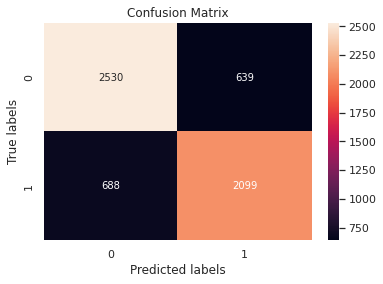

In [ ]:
predictions_3 = pipe_LR_Clf_3.predict(X_test_3)
#Calculating Confusion Matrix
CM = confusion_matrix(y_test_3, predictions_3)

# drawing confusion matrix
ax= plt.subplot()
sns.heatmap(CM, annot=True, fmt='g', ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

In [ ]:
#Calculating classification Report (precision, recall, f1-score, accuracy) on test set:  

ClassificationReport = classification_report(y_test_3, predictions_3)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.79      0.80      0.79      3169
           1       0.77      0.75      0.76      2787

    accuracy                           0.78      5956
   macro avg       0.78      0.78      0.78      5956
weighted avg       0.78      0.78      0.78      5956



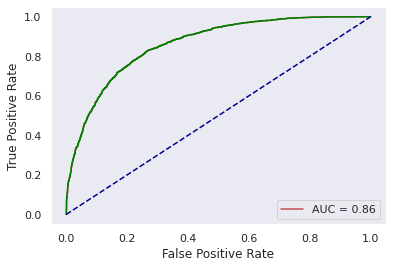

In [ ]:
#calculate and virtualize the roc curve for the test set
fpr, tpr, thresholds = roc_curve(y_test_3, pipe_LR_Clf_3.predict_proba(X_test_3)[:,1])

roc_auc = roc_auc_score(y_test_3, pipe_LR_Clf_3.predict_proba(X_test_3)[:,1])
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr, tpr, color='green', label='')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.grid()

In [ ]:
#predict and create CSV file for CSV test file
df2 = pd.read_csv('/content/drive/MyDrive/DEBI/Queens/DM/Assignment_3/x_test.csv')
submission = pd.DataFrame()
submission['id'] = df2['id']
submission['label'] = pipe_LR_Clf_3.predict_proba(df_Test['clean_text'])[:, 1]

submission.to_csv('No_pre_LR_RS_trial_4_VS4.csv', index=False)

#kaggel  0.83444
#kaggel  0.83292 

* as we see from the previous virtualization and test 
* i got 86.2% best score which it's close to my expectation and not bad 
* and give me 78% score on test data which is not good and not bad
* and give me 86% auc on test data which it's close to my expectation and not bad and not good 
* and give me 83.2 % on kaggle which it's not good 

> from all of that this model not bad and not good model now will try another model to see if there is any improvement or not



###Trail_3 (LogisticRegression with RandomSearch, 'char', validationset)

> in this trial i will use LogisticRegression Model with GridSearch approach by using pipeline and using tfidfvectorizer with **char** analyzer and different hyperparameters by using RandomSearch Tunning

in this model i expect to give me score around 70% on training and 70% auc on test set because this will work with characters not words

In [ ]:
# step 1: using TfidfVectorizer with analyzer='char'
# step 2: using LR Model
pipe_LR_Clf_4 = Pipeline([('tfidf', TfidfVectorizer(analyzer='char')),
                       ('LR_Grid', LogisticRegression(max_iter = 600, random_state=42))
                       ])


pipe_LR_Clf_4.fit(X_train_3, y_train_3)
pipe_LR_Clf_4.score(X_train_3, y_train_3)

0.5656213271645244

In [ ]:
# Further split the original training set to a train and a validation set
X_train2, X_val, y_train2, y_val = train_test_split(X_train_3, y_train_3, test_size = 0.2, stratify = y_train_3, random_state = 42)
# Create a list where train data indices are -1 and validation data indices are 0
# X_train2 (new training set), X_train
split_index_2 = [-1 if x in X_train2.index else 0 for x in X_train_3.index]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index_2)


In [ ]:
%%time
# define parameter space to test # runtime 19min
params_3 = {
    "tfidf__max_df": np.arange(0.3, 0.8),
    "tfidf__min_df": np.arange(5, 100),
    "LR_Grid__solver": [ 'lbfgs', 'liblinear', 'saga'],
    "LR_Grid__C": np.arange(0.1, 1, 0.1),
    "LR_Grid__penalty":['l1', 'l2', 'none']
}
pipe_LR_RS_clf_5 = RandomizedSearchCV(pipe_LR_Clf_4, params_3, n_iter = 50, n_jobs=-1, cv = pds, random_state=42, verbose=2, scoring="roc_auc")
pipe_LR_RS_clf_5.fit(X_train_3, y_train_3)

Fitting 1 folds for each of 50 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
7 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File 

CPU times: user 3.61 s, sys: 255 ms, total: 3.87 s
Wall time: 1min 4s


In [ ]:
print('best score {}'.format(pipe_LR_RS_clf_5.best_score_))
best_params_2 = pipe_LR_RS_clf_5.best_params_
print(best_params_2)

best score 0.5333227834109326
{'tfidf__min_df': 40, 'tfidf__max_df': 0.3, 'LR_Grid__solver': 'liblinear', 'LR_Grid__penalty': 'l1', 'LR_Grid__C': 0.1}


In [ ]:
# run pipe with optimized parameters
pipe_LR_Clf_4.set_params(**best_params_2).fit(X_train_3, y_train_3)
pipe_pred_2 = pipe_LR_Clf_4.predict_proba(X_test_3)

> **Virtualization and report for this model**

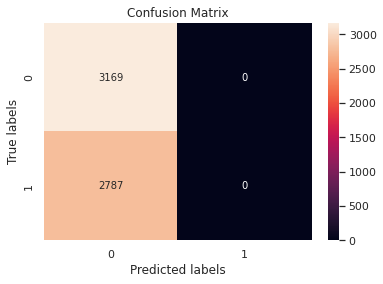

In [ ]:
predictions_4 = pipe_LR_Clf_4.predict(X_test_3)
#Calculating Confusion Matrix
CM = confusion_matrix(y_test_3, predictions_4)

# drawing confusion matrix
ax= plt.subplot()
sns.heatmap(CM, annot=True, fmt='g', ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

In [ ]:
#Calculating classification Report (precision, recall, f1-score, accuracy) on test set:  

ClassificationReport = classification_report(y_test_3, predictions_3)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.79      0.80      0.79      3169
           1       0.77      0.75      0.76      2787

    accuracy                           0.78      5956
   macro avg       0.78      0.78      0.78      5956
weighted avg       0.78      0.78      0.78      5956



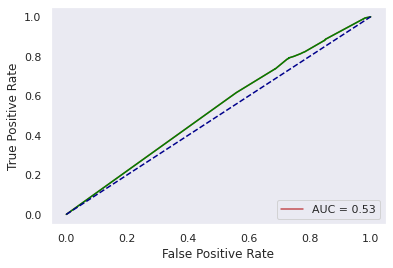

In [ ]:
#calculate and virtualize the roc curve for the test set
fpr, tpr, thresholds = roc_curve(y_test_3, pipe_LR_Clf_4.predict_proba(X_test_3)[:,1])

roc_auc = roc_auc_score(y_test_3, pipe_LR_Clf_4.predict_proba(X_test_3)[:,1])
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr, tpr, color='green', label='')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.grid()

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/DEBI/Queens/DM/Assignment_3/x_test.csv')
submission = pd.DataFrame()
submission['id'] = df2['id']
submission['label'] = pipe_LR_Clf_4.predict_proba(df_Test['clean_text'])[:, 1]

submission.to_csv('No_pre_LR_RS_trial_4_VS4.csv', index=False)

#kaggel  0.6214

* as we see from the previous virtualization and test 
* i got 56.56% best score which it isn't  close to my expectation and so bad 
* and give me 78% score on test data which is not good and not bad
* and give me 53% auc on test data which it isn't close to my expectation and this the worst results i got before
* and give me 62.1 % on kaggle which it's awful

> from all of that, this model is the worst model i used before


###Trail_4 (XGBClassifier, RandomS, char)

> in this trial i will use XGBClassifier Model with RandomSearch approach by using pipeline and using tfidfvectorizer with **char** analyzer and different hyperparameters by using RandomSearch Tunning

in this model i expect to give me score around 70% on training and 70% auc on test set because this will work with characters not words

In [ ]:
# step 1: using TfidfVectorizer with analyzer='char'
# step 2: using XGBClassifier Model
pipe_XGB_Clf_4 = Pipeline(
                        [('tfidf', TfidfVectorizer(analyzer='char')),
                        ('XGB_3', XGBClassifier(objective='binary:logistic', random_state=42))
                        ])
#, subsample = 0.7, colsample_bytree =  0.8, n_estimators = 200, max_depth = 16, 
pipe_XGB_Clf_4.fit(X_train_3, y_train_3)  
pipe_XGB_Clf_4.score(X_train_3, y_train_3)

0.6008059250415089

> using the RandomSearch for hyperparameters tuning 

In [ ]:
# XGB hyperparameters
XGB_3_params = {
    "tfidf__ngram_range": [(1, 2), (1, 3)],
    "tfidf__max_df": np.arange(0.3, 0.8),
    "tfidf__min_df": np.arange(5, 100),
    'XGB_3__n_estimators': [20, 30, 50, 100, 200, 220],  
    'XGB_3__max_depth':[10, 16, 20, 30], 
    "XGB_3__subsample": np.arange(0.4, 1, 0.1), 
    "XGB_3__colsample_bytree": np.arange(0.4, 1, 0.1)
}

In [ ]:
%%time
pipe_XGB_Random_clf_4 = RandomizedSearchCV(pipe_XGB_Clf_4, XGB_3_params, n_iter = 10, n_jobs=-1, cv = 3, random_state=42, verbose=2, scoring="roc_auc")
pipe_XGB_Random_clf_4.fit(X_train_3, y_train_3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 3min 52s, sys: 1.91 s, total: 3min 54s
Wall time: 31min 19s


In [ ]:
print('best score {}'.format(pipe_XGB_Random_clf_4.best_score_))
best_params_3 = pipe_XGB_Random_clf_4.best_params_
print(best_params_3)

best score 0.8030399974068976
{'tfidf__ngram_range': (1, 3), 'tfidf__min_df': 94, 'tfidf__max_df': 0.3, 'XGB_3__subsample': 0.4, 'XGB_3__n_estimators': 100, 'XGB_3__max_depth': 16, 'XGB_3__colsample_bytree': 0.7999999999999999}


In [ ]:
# run pipe with optimized parameters
pipe_XGB_Clf_4.set_params(**best_params_3).fit(X_train_3, y_train_3)
pipe_pred_RF_2 = pipe_XGB_Clf_4.predict_proba(X_test_3)

> **Virtualization and report for this model**

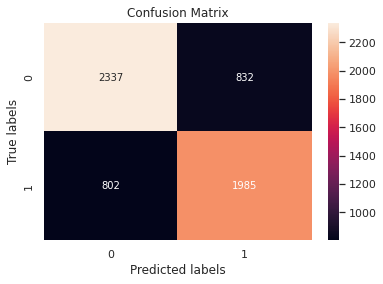

In [ ]:
predictions_3 = pipe_XGB_Clf_4.predict(X_test_3)
#Calculating Confusion Matrix
CM = confusion_matrix(y_test_3, predictions_3)

# drawing confusion matrix
ax= plt.subplot()
sns.heatmap(CM, annot=True, fmt='g', ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

In [ ]:
#Calculating classification Report (precision, recall, f1-score, accuracy) on test set:  

ClassificationReport = classification_report(y_test_3, predictions_3)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.74      0.74      0.74      3169
           1       0.70      0.71      0.71      2787

    accuracy                           0.73      5956
   macro avg       0.72      0.72      0.72      5956
weighted avg       0.73      0.73      0.73      5956



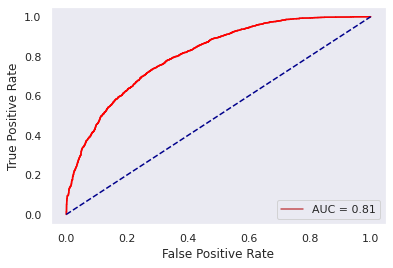

In [ ]:
#calculate and virtualize the roc curve for the test set
fpr, tpr, thresholds = roc_curve(y_test_3, pipe_XGB_Clf_4.predict_proba(X_test_3)[:,1])

roc_auc = roc_auc_score(y_test_3, pipe_XGB_Clf_4.predict_proba(X_test_3)[:,1])
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr, tpr, color='red', label='')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.grid()

In [ ]:
#predict and create CSV file for CSV test file
df2 = pd.read_csv('/content/drive/MyDrive/DEBI/Queens/DM/Assignment_3/x_test.csv')
submission = pd.DataFrame()
submission['id'] = df2['id']
submission['label'] = pipe_XGB_Clf_4.predict_proba(df_Test['clean_text'])[:, 1]

submission.to_csv('No_pre_XGB_RandomS_trial_3.csv', index=False)

#kaggel  0.75176

* as we see from the previous virtualization and test 
* i got 60% best score which it isn't close to my expectation and this is awful
* and give me 73% score on test data which is awful
* and give me 81% auc on test data which it isn't close to my expectation and bad
* and give me 75.1 % on kaggle which it's bad

> from all of that this model is bad  now will try another model to see if there is any improvement or not



###Trail_5 (RandomForest with RandomSearch)

> in this trial i will use RandomForest Model with RandomSearch approach by using pipeline and using tfidfvectorizer with **char** analyzer and default hyperparameters

in this model i expect to give me score around 88% on training and 88% auc on test set

In [44]:
%%time
# step 1: using TfidfVectorizer with analyzer='char'
# step 2: using RF Model
pipe_RF_Clf_3 = Pipeline([('tfidf', TfidfVectorizer(analyzer='char')),
                       ('RF_Random',RandomForestClassifier(random_state = 3))
                       ])


pipe_RF_Clf_3.fit(X_train_3, y_train_3)
print(pipe_RF_Clf_3.score(X_train_3, y_train_3))

1.0
CPU times: user 1min 59s, sys: 297 ms, total: 2min
Wall time: 2min 9s


In [45]:
%%time
# define parameter space to test # runtime 19min
randomForest_params = {
    # Number of trees in random forest
    'RF_Random__n_estimators': [100, 200, 400, 500, 700, 1000, 2000],
    # Maximum number of levels in tree
    'RF_Random__max_depth' : [10, 20, 40, 50, 60, 70],
    # Number of features to consider at every split
    'RF_Random__max_features': ['auto', 'sqrt']
    
}

pipe_RF_Random_clf_3 = RandomizedSearchCV(pipe_RF_Clf_3, randomForest_params, n_iter = 10, n_jobs=-1, cv = 2, random_state=42, verbose=2, scoring="roc_auc")
pipe_RF_Random_clf_3.fit(X_train_3, y_train_3)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
CPU times: user 12min 20s, sys: 3.26 s, total: 12min 24s
Wall time: 50min 31s


In [46]:
print('best score {}'.format(pipe_RF_Random_clf_3.best_score_))
best_params_2 = pipe_RF_Random_clf_3.best_params_
print(best_params_2)

best score 0.6078642653469466
{'RF_Random__n_estimators': 700, 'RF_Random__max_features': 'auto', 'RF_Random__max_depth': 20}


* as we see when i didn't use the random search the model gives me 100% score and when i used randomsearch gives me 60 score so the first time the model overfitting the data 
* and there is a problem by using randomsearch as we see that take around 1 hour for fit

In [47]:
# run pipe with optimized parameters
pipe_RF_Clf_3.set_params(**best_params_2).fit(X_train_3, y_train_3)
pipe_pred_RF_2 = pipe_RF_Clf_3.predict_proba(X_test_3)

> **Virtualization and report for this model**

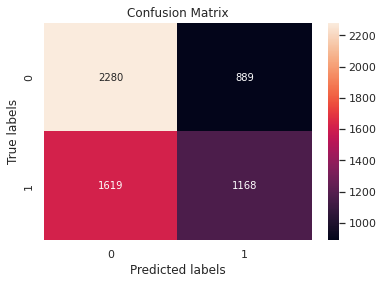

In [48]:
predictions_2 = pipe_RF_Clf_3.predict(X_test_3)
#Calculating Confusion Matrix
CM = confusion_matrix(y_test_3, predictions_2)

# drawing confusion matrix
ax= plt.subplot()
sns.heatmap(CM, annot=True, fmt='g', ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

In [49]:
#Calculating classification Report (precision, recall, f1-score, accuracy) on test set:  

ClassificationReport = classification_report(y_test_3, predictions_2)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.58      0.72      0.65      3169
           1       0.57      0.42      0.48      2787

    accuracy                           0.58      5956
   macro avg       0.58      0.57      0.56      5956
weighted avg       0.58      0.58      0.57      5956



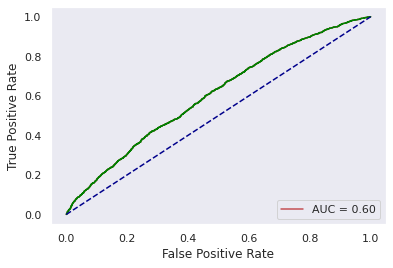

In [50]:
#calculate and virtualize the roc curve for the test set
fpr, tpr, thresholds = roc_curve(y_test_3, pipe_RF_Clf_3.predict_proba(X_test_3)[:,1])

roc_auc = roc_auc_score(y_test_3, pipe_RF_Clf_3.predict_proba(X_test_3)[:,1])
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr, tpr, color='green', label='')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.grid()

In [51]:
#predict and create CSV file for CSV test file
df2 = pd.read_csv('/content/drive/MyDrive/DEBI/Queens/DM/Assignment_3/x_test.csv')
submission = pd.DataFrame()
submission['id'] = df2['id']
submission['label'] = pipe_RF_Clf_3.predict_proba(df2['text'])[:, 1]

submission.to_csv('No_pre_RF_Random_trial_Char_1.csv', index=False)

#kaggel  0.5368

* as we see from the previous virtualization and test 
* i got 60.7% best score which it isn't close to my expectation and awful
* and give me 58% score on test data which is awful 
* and give me 60% auc on test data which it is far away from my expectation and this result is terrible
* and give me 53.6 % on kaggle which it's not good 

> from all of that this model is the bad one i used until now

> now i will use a new approach to see if there is any improve or not


-----------------------------------------------

#Load the data

In [3]:
# import data from my google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#read the data into data frame
df = pd.read_csv('/content/drive/MyDrive/DEBI/Queens/DM/Assignment_3/xy_train.csv')
#display the first 5 rows of dataframe
df.head()

,id,text,label
0,265723,A group of friends began to volunteer at a hom...,0
1,284269,British Prime Minister @Theresa_May on Nerve A...,0
2,207715,"In 1961, Goodyear released a kit that allows P...",0
3,551106,"Happy Birthday, Bob Barker! The Price Is Right...",0
4,8584,"Obama to Nation: 聙""Innocent Cops and Unarmed Y...",0


#Trial Number Four For Data Preprocessing

i will check if there ara any null values or not to handle that problem if exist

##handel missing Values

In [5]:
#check for the columns which have the heights nun values
df.isnull().sum().sort_values(ascending=False)

id       0
text     0
label    0
dtype: int64

as we see the data has zero null values

In [6]:
#virtualize the data correlation
corr = df.corr()

corr.style.background_gradient(cmap="Spectral")

,id,label
id,1.000000,0.000687
label,0.000687,1.000000


##Handling the target column

Checking the uniques values for label column because the range of label column must be zero or one

In [7]:
df['label'].value_counts()

0    32172
1    27596
2      232
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


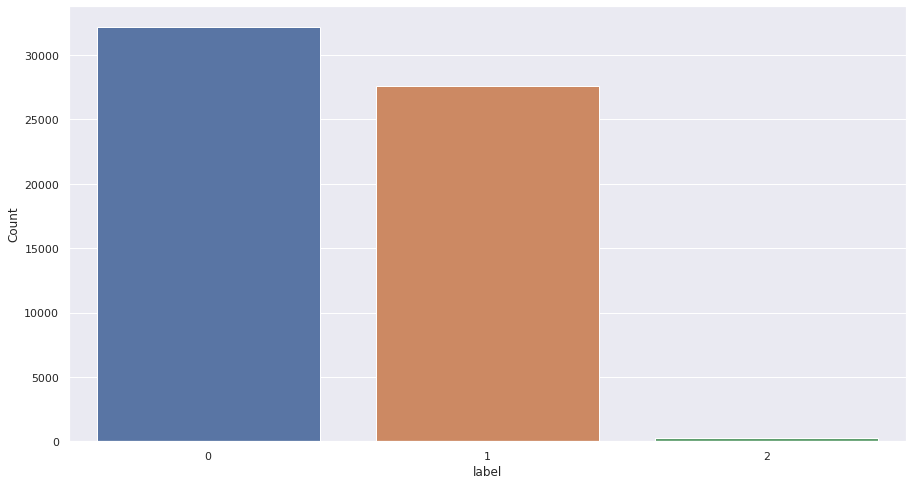

In [8]:
# checking for distribution of label column before handling
fig, ax = plt.subplots(figsize = (15, 8))
sns.countplot('label', data = df, order = df['label'].value_counts().index, ax = ax)
ax.set(xlabel='label', ylabel='Count')
plt.show()

as we see we have 3 unique values for label column so i will convert all label value (2) to be (1)

i will create new column (grade_bad) has all values 0 then check on the label column then i will update the values in grade_bad column
* if label column has value 0 then i will fill grade_bad with (zero)
* else if the label column has value more than (zero) i will fill grade_bad with (one)

In [9]:
df["new_label"] = 0
df.loc[df["label"] == 0, "new_label"] = 0
df.loc[df["label"] > 0, "new_label"] = 1

In [10]:
#checking for the distribution of grade_bad
df['new_label'].value_counts()

0    32172
1    27828
Name: new_label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


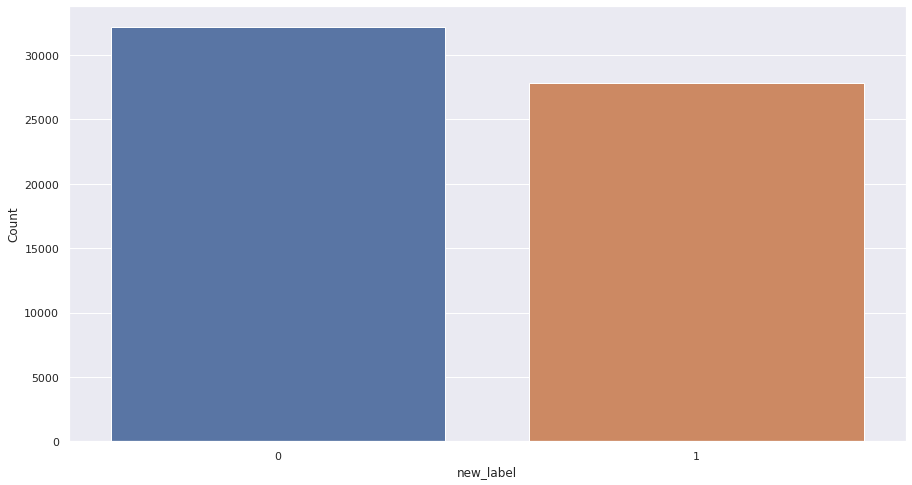

In [11]:
# checking for distribution of new_label column after handling
fig, ax = plt.subplots(figsize = (15, 8))
sns.countplot('new_label', data = df, order = df['new_label'].value_counts().index, ax = ax)
ax.set(xlabel='new_label', ylabel='Count')
plt.show()

In [12]:
#Checking if the new_label is balance or not
df["new_label"].value_counts(normalize=True)

0    0.5362
1    0.4638
Name: new_label, dtype: float64

as we see the data is balance which is good

##handeling Duplication

In [13]:
#describe the text column
df['text'].describe()

count                                                 60000
unique                                                59645
top       /r/Fakehistoryporn subscribers as they attempt...
freq                                                     14
Name: text, dtype: object

Remove all rows which duplicated

print the sum number of duplicated values in text column

In [14]:
df['text'].duplicated().sum()

355

In [15]:
df[df['text'].duplicated()]

,id,text,label,new_label
417,213389,Virginia Governor signs historic coal ash clea...,1,1
579,169958,"Joni Ernst, Mike Lee roll out conservative pai...",1,1
617,127721,Scientists from Purdue University have devised...,1,1
712,86881,Gov. Laura Kelly attracts crowd for signing of...,1,1
1095,410748,"Chinese-American architect I. M. Pei, one of t...",1,1
...,...,...,...,...
58638,547738,This framed photo of a slice of toast that loo...,0,0
58775,210611,New Department Of Agriculture Study Finds 85% ...,0,0
58849,213125,Committee approves a bill to place Helen Kelle...,1,1
58934,170699,The less Americans know about Ukraine鈥檚 locati...,1,1


Remove the duplicated rows

In [16]:
df.drop_duplicates('text',inplace = True)

as we see we have 59645 unique values out of 60000 rows so in the first i will let them and try my model then i will remove them and compare the results

##Handeling Text Column

In [17]:
# Downloading stopwords package
nltk.download("stopwords")
stopwords_ = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

**remove some special char and links and spaces and punctuation and convert the words to lowe case and drop the stopwords**

In [19]:
documents = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()
# stemmer = SnowballStemmer(language='english')

def simple_clear(text):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(text))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # document = re.sub(r'<.*?>s+', ' ', document)
    # document = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", ' ', document)
    # document = re.sub(r'\[|\(.*\]|\)', ' ', document)
    # document = re.sub(r'\S*\d\S*\s*', ' ', document)
    # document = re.sub(r"\b[A-Za-zÀ-ž]\b", ' ', document)
    # document = re.sub(r"[^A-Za-zÀ-ž,.!? ]", ' ', document)
    # document = re.sub(r"\b[A-Za-zÀ-ž,.!?]\b", ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document if not word in stopwords_]
    document = ' '.join(document)
    
    documents.append(document)
    return document

In [20]:
#apply the simple_clear Function on text column and create a new column called clean_text column
df['clean_text'] = df['text'].apply(simple_clear)

##handeling Cleen_text Column

Check for duplications

In [21]:
df['clean_text']

0        group friend began volunteer homeless shelter ...
1        british prime minister theresa_may nerve attac...
2        1961 goodyear released kit allows ps2s brought...
3        happy birthday bob barker price right host lik...
4        obama nation 聙 innocent cop unarmed young blac...
                               ...                        
59995    finish sniper simo h盲yh盲 invasion finland ussr...
59996    nigerian prince scam took 110k kansa man 10 ye...
59997    safe smoke marijuana pregnancy you鈥檇 surprised...
59998    julius caesar upon realizing everyone room kni...
59999    jeff bridge releasing 鈥楽leeping tape 鈥 new alb...
Name: clean_text, Length: 59645, dtype: object

In [22]:
df['clean_text'].duplicated().sum()

54

as we see we have 54 rows duplicated so i will drop this rows

In [23]:
df[df['clean_text'].duplicated()]

,id,text,label,new_label,clean_text
272,505455,A woman was nearly killed after teens threw a ...,1,1,woman nearly killed teen threw 20 lb frozen tu...
1313,308899,"You mean, let me understand this cause, ya kno...",0,0,mean let understand cause ya know maybe little...
5153,254496,My dad (far left) in Vietnam in 1971. Didn't k...,0,0,dad far left vietnam 1971 know photo existed c...
5347,541264,My Dad (front) in Vietnam in 1971. Didn't know...,0,0,dad front vietnam 1971 know photo existed came...
5366,450739,My Dad (front) in Vietnam in 1971. Didn鈥檛 know...,0,0,dad front vietnam 1971 didn鈥檛 know photo exist...
5367,388054,My dad (front) in Vietnam in 1971. Didn't know...,0,0,dad front vietnam 1971 know photo existed came...
5451,339072,My Dad (right) in Vietnam in 1971. Didn't know...,0,0,dad right vietnam 1971 know photo existed came...
5463,428235,My Dad (Front) in Vietnam in 1971. Didn't know...,0,0,dad front vietnam 1971 know photo existed came...
5531,443277,My dad (right) in Vietnam 1971. Didn't know th...,0,0,dad right vietnam 1971 know photo existed came...
5714,399146,My dad (front) in Vietnam 1971. Didn't know th...,0,0,dad front vietnam 1971 know photo existed came...


In [24]:
#check for the columns which have the heights nun values
df.isnull().sum().sort_values(ascending=False)

id            0
text          0
label         0
new_label     0
clean_text    0
dtype: int64

> as we see there is no null values which is good

as we see we have a duplicate values in Cleen_text column so i will drop that duplicates and then create a pipeline with tfidfvectorize to train the model

drop the duplication rows

In [25]:
df.drop_duplicates('clean_text',inplace = True)

In [26]:
df['clean_text'].duplicated().sum()

0

In [27]:
df[df['clean_text'].duplicated()]

,id,text,label,new_label,clean_text


---

We need also to apply the 'simple_clear' function on the test data. to handle this data to be the same as training data

In [28]:
df2 = pd.read_csv('/content/drive/MyDrive/DEBI/Queens/DM/Assignment_3/x_test.csv')

df2['clean_text'] = df2['text'].apply(simple_clear)

In [29]:
df2

,id,text,clean_text
0,0,stargazer,stargazer
1,1,yeah,yeah
2,2,PD: Phoenix car thief gets instructions from Y...,pd phoenix car thief get instruction youtube v...
3,3,"As Trump Accuses Iran, He Has One Problem: His...",trump accuses iran one problem credibility
4,4,"""Believers"" - Hezbollah 2011",believer hezbollah 2011
...,...,...,...
59146,59146,Bicycle taxi drivers of New Delhi,bicycle taxi driver new delhi
59147,59147,Trump blows up GOP's formula for winning House...,trump blow gop formula winning house race
59148,59148,Napoleon returns from his exile on the island ...,napoleon return exile island elba march 1815 c...
59149,59149,Deep down he always wanted to be a ballet dancer,deep always wanted ballet dancer


#split the data to features and target

**target data**

In [30]:
Y = df['new_label']
print(Y.shape)

(59591,)


**Features Data**

this data will change depend on the data preprocessing i did or i will do

In [31]:
X = df['clean_text']
#print the shape for features
print(X.shape)

(59591,)


Split the training data into training set and test set to test results local 

In [32]:
#split the training set inot 90% training and 10% test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (53631,)
X_test: (5960,)
y_train: (53631,)
y_test: (5960,)


#ML Models

##Trail_1 (LogisticRegression with GridSearch)

> in this trial i will use LogisticRegression Model with GridSearch approach by using pipeline and using tfidfvectorizer with the default hyperparameters

in this model i expect to give me score around 90% on training and 90% auc on test set

In [44]:
# step 1: using TfidfVectorizer with default hyperparameters
# step 2: using LR Model
pipe_LR_Clf_2 = Pipeline([('tfidf', TfidfVectorizer()),
                       ('LR_Grid', LogisticRegression(max_iter = 500, random_state=42))
                       ])


pipe_LR_Clf_2.fit(X_train, y_train)
pipe_LR_Clf_2.score(X_train, y_train)

0.8663273106971714

now i will use the Validation set and GridSearch

In [45]:
# Further split the original training set to a train and a validation set
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train, random_state = 42)
# Create a list where train data indices are -1 and validation data indices are 0
# X_train2 (new training set), X_train
split_index_2 = [-1 if x in X_train2.index else 0 for x in X_train.index]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index_2)


> using the RandomSearch for hyperparameters tuning 

In [46]:
%%time
# define parameter space to test # runtime 19min
params_2 = {
    "tfidf__ngram_range": [(1, 2), (1, 3)],
    "tfidf__max_df": np.arange(0.3, 0.8),
    "tfidf__min_df": np.arange(5, 100),
    "LR_Grid__solver": [ 'lbfgs', 'saga'],
    "LR_Grid__C": np.arange(0.1, 1, 0.15),
    "LR_Grid__penalty":['l1', 'l2']
}
pipe_LR_Grid_clf_2 = RandomizedSearchCV(pipe_LR_Clf_2, params_2, n_jobs=-1, n_iter = 200, cv = pds, verbose=2, scoring="roc_auc")
pipe_LR_Grid_clf_2.fit(X_train, y_train)

Fitting 1 folds for each of 200 candidates, totalling 200 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fi

CPU times: user 13.7 s, sys: 951 ms, total: 14.7 s
Wall time: 7min 41s


In [47]:
#best score and hyperparameter from tunning
print('best score {}'.format(pipe_LR_Grid_clf_2.best_score_))
best_params_2 = pipe_LR_Grid_clf_2.best_params_
print(best_params_2)

best score 0.8801543447685439
{'tfidf__ngram_range': (1, 3), 'tfidf__min_df': 8, 'tfidf__max_df': 0.3, 'LR_Grid__solver': 'saga', 'LR_Grid__penalty': 'l2', 'LR_Grid__C': 0.5499999999999999}


In [48]:
# run pipe with optimized parameters
pipe_LR_Clf_2.set_params(**best_params_2).fit(X_train, y_train)
pipe_pred_2 = pipe_LR_Clf_2.predict_proba(X_test)

> **Virtualization and report for this model**

In [52]:
#Calculating classification Report (precision, recall, f1-score, accuracy) on test set:  

ClassificationReport = classification_report(y_test, predictions_2)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.82      0.81      0.82      3163
           1       0.79      0.80      0.80      2797

    accuracy                           0.81      5960
   macro avg       0.81      0.81      0.81      5960
weighted avg       0.81      0.81      0.81      5960



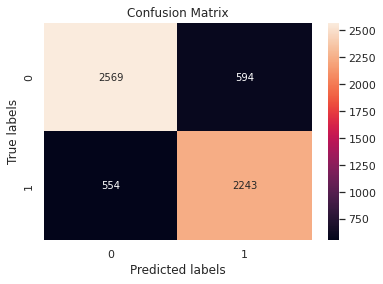

In [49]:
predictions_2 = pipe_LR_Clf_2.predict(X_test)
#Calculating Confusion Matrix
CM = confusion_matrix(y_test, predictions_2)

# drawing confusion matrix
ax= plt.subplot()
sns.heatmap(CM, annot=True, fmt='g', ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

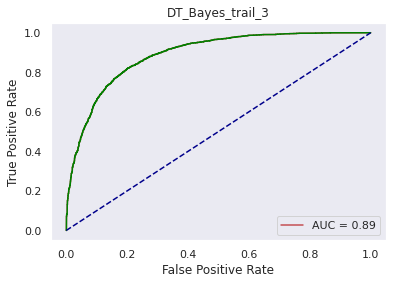

In [50]:
#calculate and virtualize the roc curve for the test set
fpr, tpr, thresholds = roc_curve(y_test, pipe_LR_Clf_2.predict_proba(X_test)[:,1])

roc_auc = roc_auc_score(y_test, pipe_LR_Clf_2.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr, tpr, color='green', label='')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DT_Bayes_trail_3')
plt.legend(loc = 'lower right')
plt.grid()

In [51]:
#predict and create CSV file for CSV test file
submission = pd.DataFrame()
submission['id'] = df2['id']
submission['label'] = pipe_LR_Clf_2.predict_proba(df2['clean_text'])[:, 1]

submission.to_csv('No_pre_LR_Grid_trial_last_good_86.csv', index=False)

#kaggel  0.86031


* as we see from the previous virtualization and test 
* i got 88% best score which it's not close to my expectation and good 
* and give me 81% score on test data which is good
* and give me 89% auc on test data which it's close to my expectation and good and this is better than the previous one 
* and give me 86.03 % on kaggle which is good but this is the second best score until now

> from all of that this model is good but i will try another model to see if there is any improvement or not



##XGB Classifier

> in this trial i will use XGBClassifier Model by using pipeline and using tfidfvectorizer with the default hyperparameters

in this model i expect to give me score around 90% on training and 90% auc on test set

In [ ]:
# step 1: using TfidfVectorizer with default hyperparameters
# step 2: using XGBClassifier
pipe_XGB_Clf_2 = Pipeline(
                        [('tfidf', TfidfVectorizer()),
                        ('XGB', XGBClassifier(objective='binary:logistic', subsample = 0.7, colsample_bytree =  0.8, n_estimators = 200, max_depth = 16, random_state=42))
                        ])

pipe_XGB_Clf_2.fit(X_train, y_train)  
pipe_XGB_Clf_2.score(X_train, y_train)

0.8902769725645677

> **Virtualization and report for this model**

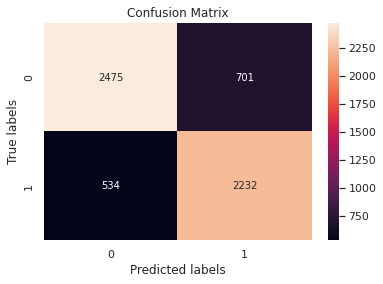

In [ ]:
predictions_2 = pipe_XGB_Clf_2.predict(X_test)
#Calculating Confusion Matrix
CM = confusion_matrix(y_test, predictions_2)

# drawing confusion matrix
ax= plt.subplot()
sns.heatmap(CM, annot=True, fmt='g', ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

In [ ]:
#Calculating classification Report (precision, recall, f1-score, accuracy) on test set:  

ClassificationReport = classification_report(y_test, predictions_2)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.82      0.78      0.80      3176
           1       0.76      0.81      0.78      2766

    accuracy                           0.79      5942
   macro avg       0.79      0.79      0.79      5942
weighted avg       0.79      0.79      0.79      5942



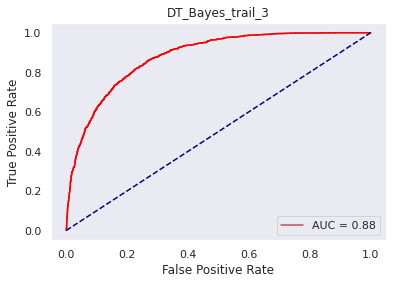

In [ ]:
#calculate and virtualize the roc curve for the test set
fpr, tpr, thresholds = roc_curve(y_test, pipe_XGB_Clf_2.predict_proba(X_test)[:,1])

roc_auc = roc_auc_score(y_test, pipe_XGB_Clf_2.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr, tpr, color='red', label='')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DT_Bayes_trail_3')
plt.legend(loc = 'lower right')
plt.grid()

In [ ]:
#predict and create CSV file for CSV test file
df2 = pd.read_csv('/content/drive/MyDrive/DEBI/Queens/DM/Assignment_3/x_test.csv')
submission = pd.DataFrame()
submission['id'] = df2['id']
submission['label'] = pipe_XGB_Clf_2.predict_proba(df2['text'])[:, 1]

submission.to_csv('No_pre_XGB_trial_last_85.csv', index=False)

#kaggel  0.81566

* as we see from the previous virtualization and test 
* i got 89% score which it's close to my expectation and good 
* and give me 79% score on test data which is not bad
* and give me 88% auc on test data which it's close to my expectation and good
* and give me 81.5 % on kaggle which is not bad and not very good

> from all of that this model not bad and also not good



So from the last time i said LR model which give me 86.157 socre is good and then no model can skip this result so this model is the best model

# Problem Formulation

### **Define the problem:**
> This is a binary classification tast.

>we are going to predict if a specific reddit post is a fake news or not by looking only at the title  

>we have a data contains various forms of words, so we working on NLP problem 

### **What is the input?**

> We have a data contains various forms of words.

> The input data is in a text format. 

>which is The title of reddit posts .It's a labelled data set with labels of 1 or 0, indicating if the news is fake or not.

### **What is the output?**
> Is a prediction of if a specific reddit post is fake news or not . But the actual output file is focused on the probability of the fake news.


### **What data mining function is required?**



> The data mining functions i used are:

* importing the libraries

  > which used in the models and to help me to deal with many things

* load the data
  > to deal with the model to make a prediction

* virtualize the data and some columns
  > to help me to find any information or pattern

* Data preprocessing : Here i used many approaches 
    
    * The first approach 
    > checking the Null values

    > handling the target columns {the range of values is 0 or 1}
    
    > checking for any dublicates and i didn't drop them in this approache.
    
    > splitting the data into feature and target data 
    
    > then splitting the data into training 90 % and testing with 10 % for testing 

    > for the text preprocessing i used TF-IDF vectorizer with default hyperparameters to handling the text column.

    * The second approach 
        > checking the Null values

        > handling the target columns [the range of values is 0 or 1]

        > checking for any dublicates and i drop them in this approache.

        > splitting the data into feature and target data 

        > then splitting the data into training 90 % and testing with 10 % for testing 
        
        > for the text preprocessing i used TF-IDF vectorizer with default hyperparameters to handling the text column.
 
  * The Third approach 
      > checking the Null values

      > handling the target columns [the range of values is 0 or 1]

      > checking for any dublicates and i drop them in this approache.

      > Handling text column by using word lemmitizer with regulare expretion [remove stop words / using stemmer to steme the words / remove special characters ,  URLS , white spaces and digites and punctuation by using regulare expretion ] 

      > after this handling i droped duplicated rows

      > splitting the data into feature and target data 

      > then splitting the data into training 90 % and testing with 10 % for testing 

  * The fourth approach  : this approach is close to the third approach but the difference in handling the text column by using word lemmitizer not using stemmer by using differente regulare expretion

      > checking the Null values

      > handling the target columns [the range of values is 0 or 1]

      > checking for any dublicates and i drop them in this approache.

      > Handling text column by using word lemmitizer and regulare expretion [remove stop words / using stemmer to steme the words / remove special characters ,  URLS , white spaces and digites and punctuation by using regulare expretion ] 

      > after this handling i droped duplicated rows

      > splitting the data into feature and target data 

      > then splitting the data into training 90 % and testing with 10 % for testing 


* Hyperparameters Tunning : 
  
  > use many methods for find the optimal hyperparameters
    * GrideSearch
    * RandomeSearch

* use many methods for find the optimal hyperparameters
    * XGBClassifier Model
    * RandomForestClassifier Model
    * LogisticRegression Model


### **What could be the challenges?**


> The challenges for data 
  * deal with null values
  * deal with duplications
  * deal with ranges of values 
  * deal with the preprocessing of text column

> The challenges for models
  * how to chose the optimal hyperparamters
  * how to improve ethe perormance of the models
  * how to find the best ROC_AUC
  * the biggest problem that i faced is the time for hyperparameters Tunning which some models take around 2 hours to fit 

### **What is the impact?**


> The benefit of not spreading rumours through social networking sites is that it reduces the damage caused by misrepresenting the facts and increases people's faith in social networking sites and catch how write this fake post . 




### **What is an ideal solution?**

> An ideal solution will effectively address these problems by optimising hyperparameters to make the most correct estimates possible.

**And the best solution I found was by using the Logistic Regression with Grid search by using the first approach for data preprocessing which give me around 90 % score for training and give me around 90 % roc curve on local data and give me 86.1 % on kaggle **


---

# **The Questions**

1.   ## **What is the difference between Character n-gram and Word n-gram? Which one tends to suffer more from the OOV issue?**

> **Ans:**\
 Word n-gram computes how much a word is repeated based on the given number which means spliting whole text based on words, **whereas** character n-gram computes how much a character is repeated based on the selected number which means spliting each words based on character .

>For a given document in a language, there are more character N-grams repetitions than word n-gram repetitions,
i.e. a character N-grams split highlights some common properties that a word n-gram split does not.









> Because of the new terms that exist in the testing dataset but do not occur in the training dataset, word n-grams are more likely to suffer from Out Of Vocabulary (OOV) issues.

> On the other hand, character Tokenizers handle OOV words in a logical manner by preserving the word's information.
It deconstructs the OOV word into characters and represents it using these characters.
It also restricts the vocabulary's size.
because each of the 26 vocabulary words has its own set of characters

> [source](https://devopedia.org/n-gram-model) \

> [source](https://arxiv.org/pdf/1607.02789.pdf) \

> [source](https://aclanthology.org/W18-6473.pdf) \

> [source](https://towardsdatascience.com/understanding-word-n-grams-and-n-gram-probability-in-natural-language-processing-9d9eef0fa058) 

---

2.  ## **What is the difference between stop word removal and stemming? Are these techniques language-dependent?**

> **Ans:**\
 Stop word removal is one of the most commonly used preprocessing steps across different NLP applications. The idea is simply removing the words that occur commonly across all the documents in the corpus but not add much value to the meaning of the text, (such as 'the', 'is', 'a').

> But , Stemming is a natural language processing technique that lowers inflection in words to their root forms, hence aiding in the preprocessing of text, words, and documents for text normalization.
played, playing:  play

> Stop words vary from language to language so, stop words removal  is language dependent and the stemming needs to know the type of the language to get the root of its words, so it's language dependent as well .


> [Source](https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a)

> [source](https://www.oreilly.com/library/view/natural-language-processing/9781787285101/ch02s07.html#:~:text=Stop%20word%20removal%20is%20one,generally%20classified%20as%20stop%20words.)


---

3.   **Is tokenization techniques language dependent? Why?**

> **Ans:** 

>White space tokenization based on languages ​​that have white spaces between words like English and French On the other hand, Chinese language doesn't have spaces between words. Therefore, Dictionary-based tokenization is useful for Chinese because in this method tokens are found based on the tokens already in the Dictionary. If the token is not found, special rules are used to mark it. It is an advanced technology compared to the white space token.

>and rule-based tokenization, in this technique a set of rules is created for a specific problem. the tokenization is done based on rules. For example creating grammar rules as grammar for a specific language.

> and there are many approaches for tokenization





---

> 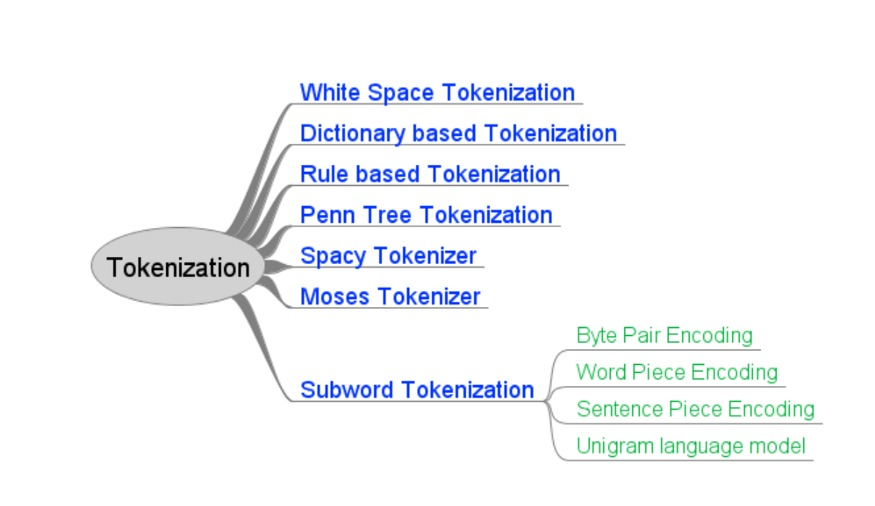


[Source](https://towardsdatascience.com/tokenization-for-natural-language-processing-a179a891bad4)

[Source](https://www.quora.com/What-is-the-difference-between-TfidfVectorizer-and-CountVectorizer-1)

4.   **What is the difference between count vectorizer and tf-idf vectorizer? Would it be feasible to use all possible n-grams? If not, how should you select them?**

> **Ans:**\
 Count Vectorizer is a way to convert a given set of strings into a frequency representation.

> TF-IDF means Term Frequency - Inverse Document Frequency. This is a statistic that is based on the frequency of a word in the corpus but it also provides a numerical representation of how important a word is for statistical analysis.

> TfidfVectorizer and CountVectorizer both are methods for converting text data into vectors as model can process only numerical data. 
In CountVectorizer we only count the number of times a word appears in the document which results in biasing in favour of most frequent words. this ends up in ignoring rare words which could have helped is in processing our data more efficiently.
To overcome this , we use TfidfVectorizer .
In TfidfVectorizer we consider overall document weightage of a word. It helps us in dealing with most frequent words. Using it we can penalize them. TfidfVectorizer weights the word counts by a measure of how often they appear in the documents.

> It isn't feasible to use all possible n-grams

> The N-gram range determines which attributes will be utilised to characterise texts: (n-gram size = 1) Unigrams or words Bigrams (n-gram size = 2) are terms made up of two words. Trigrams (n-gram size = 3) are terms made up of up to three words.

>I should select between them depend on problem like :Sentiment Analysis, setting n-gram ranges that use bigrams or trigrams can dramatically improve the accuracy of classification,as they can capture more complex expressions formed by the composition of morethan one word. The rationale is that in Sentiment Analysis the outcome dependsnot only on the frequency of words but also on how they are combined:good has a different meaning alone than when preceded by a not as in not good.


> [Ref](https://www.linkedin.com/pulse/count-vectorizers-vs-tfidf-natural-language-processing-sheel-saket#:~:text=TF%2DIDF%20is%20better%20than,by%20reducing%20the%20input%20dimensions.)

> [Ref](https://help.monkeylearn.com/en/articles/2174105-n-gram-range#:~:text=For%20problems%20like%20Sentiment%20Analysis,of%20more%20than%20one%20word.) 



---